# AB-тестирование
## Задание AB.5


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---

**Баллы за задание:**

* Задача 1 — 50 баллов
* Задача 2 — 30 баллов
* Задача 3 — 120 баллов


In [ ]:
# Bot check

# HW_ID: ds_ab5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from statsmodels.stats.proportion import proportion_confint
from IPython.display import display

from joblib import Parallel, delayed

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)


In [1]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 200  # Размер выборок
n_iter = 5000  # Количество итераций валидации
feature = 'session_lengths'

Приветик! Перед тобой очередное захватывающее домашнее задание по АБ-тестированию. Возьми чай или кофе, усаживайся поудобнее, настрой музыку в свой ритм, и поехали!

---

### Задача 1.

Начнем с очень простой задачки для разогрева. Напомним, для ratio-метрик мы хотим подобрать критерий, удовлетворяющий следующим свойствам:
1. Корректность &mdash; контролирование вероятности ошибки 1 рода;
2. Сонаправленность метрики критерия с исходной ratio-метрикой;
3. Возможность применения CUPED для повышения чувствительности.

Возьмем функцию генерации искусственных данных с занятия, в которой также генерируются предэкспериментальные данные. Будем рассматривать 1000 пользователей.

**1.** Проверь визуально, насколько выполняется сонаправленность для метода бакетов в зависимости от количества бакетов. Рассмотри случаи 10, 20, 30, 50 бакетов, и, может быть, несколько других.

*Ты же понимаешь, что надо позапускать код с занятия для разных параметров? :)*

In [3]:
def generate_session_sample(
    n_users=100, min_session_count=0, max_session_count=30, effect=0
):
    """
    Генерация данных пользовательских сессий

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    effect -- добавляемый эффект
    """

    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    # Количество сессий каждого пользователя
    user_session_counts = np.random.randint(
        size=n_users, low=min_session_count, high=max_session_count + 1
    )

    users = []
    session_lengths = []
    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            * (1 + effect)
        )

    # Заносим в табличку
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
        }
    )

    return data

In [4]:
data = generate_session_sample(n_users=1000)
data.head()

user_id  session_lengths
0    id_0         4.323577
1    id_0         7.156785
2    id_0         6.260212
3    id_0         2.107530
4    id_0         4.666733

In [4]:
def bucket_transform(
    data,
    numerator_name="session_lengths",
    user_name="user_id",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """

    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by="bucket")[[numerator_name, denominator_name]].sum()
    groupped_data["values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    return groupped_data


def generate_transform(
    n_users=100,
    min_session_count=0,
    max_session_count=30,
    num_buckets=10,
    effect=0,
):
    """
    Функция, объединяющая генерацию данных и их бакет-преобразование.

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    """

    data = generate_session_sample(
        n_users=n_users,
        min_session_count=min_session_count,
        max_session_count=max_session_count,
        effect=effect,
    )

    return bucket_transform(data, num_buckets=num_buckets)["values"]

def bucket_metric(
    data, numerator_name, user_name="user_id", denominator_name=None, num_buckets=10
):
    """
    Вычисляет метрики отдельно по бакетам

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    bucket_data = bucket_transform(
        data,
        numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=num_buckets,
    )

    return bucket_data["values"].mean()

def metric_sampler(
    generate_sample, metrics, target_name, n_iter=10000, sample_size=1000
):
    """
    Генерация значений разности средних по группам для разных метрик.

    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    """

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x = generate_sample(sample_size)
        y = generate_sample(sample_size)

        for j, metric in enumerate(metrics):
            test = metric(x, target_name)
            control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

def ratio_metric(data, numerator_name, denominator_name=None):
    """
    Вычисляет ratio-метрику

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name="user_id", denominator_name=None
):
    """
    Вычисляет метрики отдельно по пользователям

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    groupped_data = data.groupby(user_name)

    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = (
            groupped_data[numerator_name].sum()
            / groupped_data[denominator_name].sum()
        )
        return users_values.mean()

In [6]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric, lambda x, target: bucket_metric(x, target, num_buckets=10)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

  0%|          | 0/5000 [00:00<?, ?it/s]

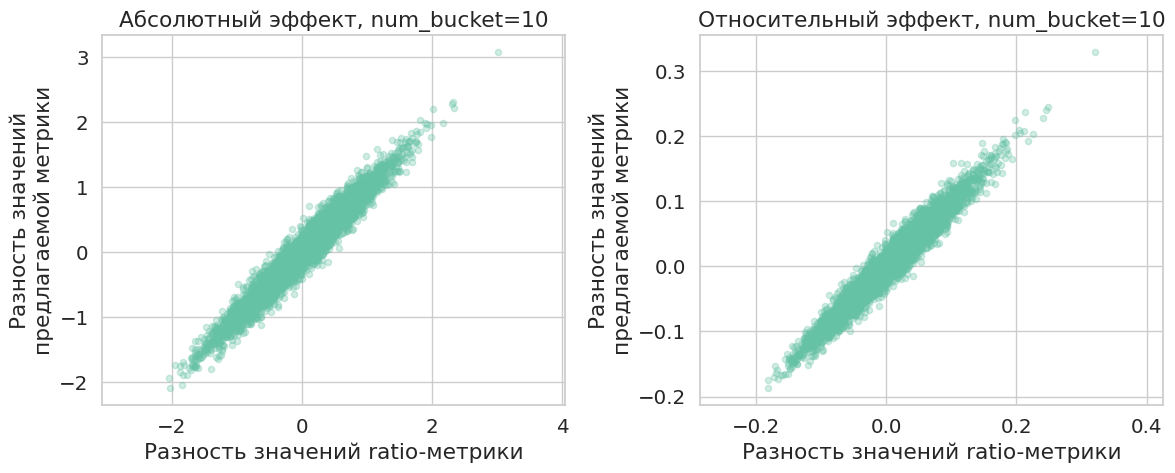

In [7]:
def plot_metric_differences(values_absolute, values_relative, title):
    plt.figure(figsize=(12, 5))
    for i, value, tmp_title in zip(
        [1, 2],
        [values_absolute, values_relative],
        ['Абсолютный эффект, ' + title, 'Относительный эффект, ' + title]
    ):
        plt.subplot(1, 2, i)
        plt.scatter(value[0], value[1], s=20, alpha=0.3)
        plt.xlabel('Разность значений ratio-метрики')
        plt.ylabel('Разность значений\nпредлагаемой метрики')
        plt.title(tmp_title)
        plt.axis('equal')
    
    plt.tight_layout()

plot_metric_differences(values_absolute, values_relative, title="num_bucket=10")

  0%|          | 0/5000 [00:00<?, ?it/s]

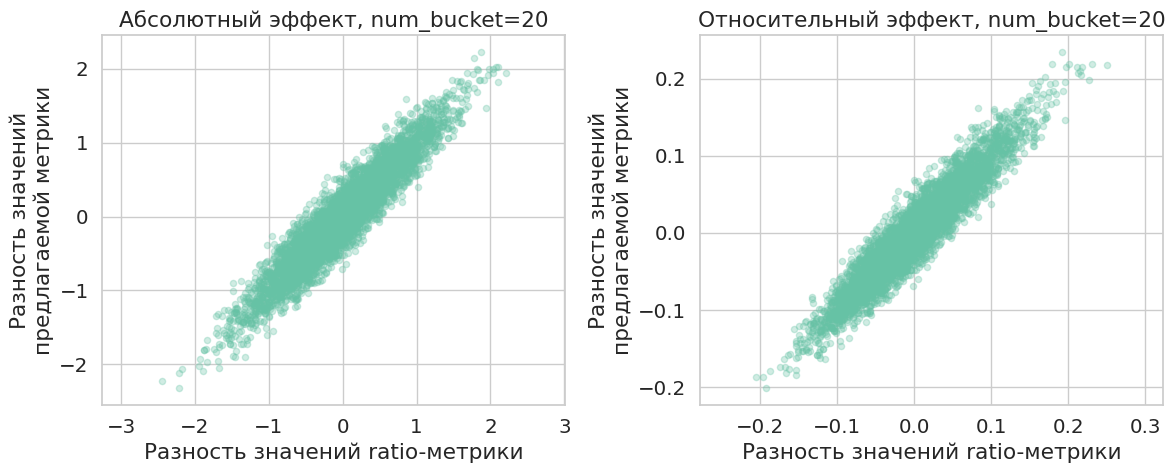

In [8]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric, lambda x, target: bucket_metric(x, target, num_buckets=20)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_metric_differences(values_absolute, values_relative, title="num_bucket=20")

  0%|          | 0/5000 [00:00<?, ?it/s]

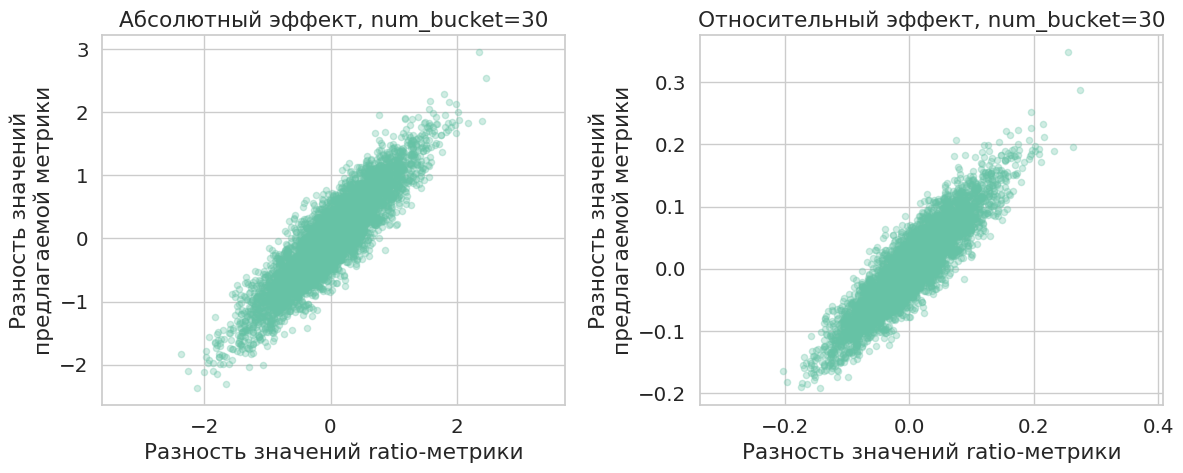

In [9]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric, lambda x, target: bucket_metric(x, target, num_buckets=30)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_metric_differences(values_absolute, values_relative, title="num_bucket=30")

  0%|          | 0/5000 [00:00<?, ?it/s]

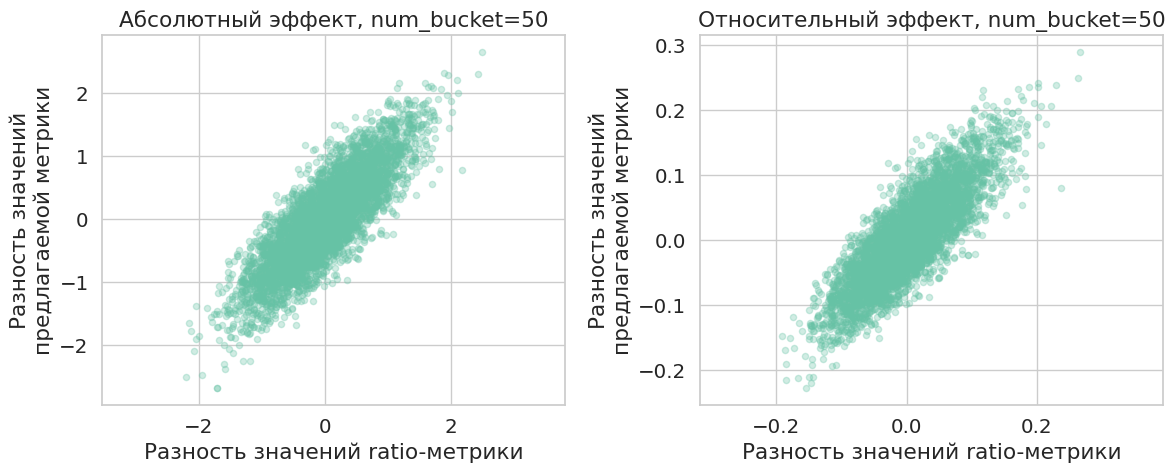

In [10]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric, lambda x, target: bucket_metric(x, target, num_buckets=50)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_metric_differences(values_absolute, values_relative, title="num_bucket=50")

В каком случае можно говорить о приближенной сонаправленности?

Приближенная сонаправленность есть при 10 бакетах, и возможно при 20 бакетах, в остальных случаях наблюдается слишком сильный разброс.

**2.** Давай все же попробуем сделать CUPED в методе бакетов, может нам зря рассказывали про линеаризацию...

Для начала внедрим CUPED в метод бакетов. Не забудь, что CUPED-преобразование необходимо применять непосредственно к бакетам, а не к исходным пользователям.

*Подсказка.* При определении бакетов удобно сделать группировку по двум полям сразу &mdash; по номеру бакета и по номеру периода. Далее надо будет смерджить горизонтально две части таблицы по периодам, то есть каждый бакет должен быть представлен только одной строкой, в которой будут данные за оба периода.

In [5]:
def generate_session_sample_with_prepilot(
    n_users=100, mean_session_count=15, effect=0
):
    """
    Генерация данных пользовательских сессий для двух последовательных периодов.

    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    """

    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)

    # Количество сессий каждого пользователя.
    # Генерируем в два раза больше, чтобы хватило на два периода.
    user_session_counts = 2 + np.random.poisson(
        size=n_users, lam=2 * mean_session_count
    )

    users = []
    period = []
    session_lengths = []

    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            + effect
        )

        # В предположении, что все сессии равномерно распределены во времени,
        # количество сессий в каждом периоде имеет биномиальное распределение
        # с параметрами n=кол-во сессий и p=1/2.
        count = np.random.binomial(n=user_session_counts[user_id], p=0.5)

        # Исключаем случаи, когда в одном из периодов нет сессий
        count = min(max(1, count), user_session_counts[user_id] - 1)

        # Определяем периоды
        period += [1] * count
        period += [0] * (user_session_counts[user_id] - count)

    # Заносим в табличку
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
            "period": np.array(period, dtype=int),
        }
    )

    return data

In [12]:
data = generate_session_sample_with_prepilot(n_users=1000)
data.head()

user_id  session_lengths  period
0    id_0        17.052658       1
1    id_0        21.039613       1
2    id_0        15.421736       1
3    id_0        11.158070       1
4    id_0        14.923987       1

Бакеты возьмем по пользователю.

In [13]:
transformed_data = data.groupby(["user_id", "period"]).mean()
transformed_data.head()

session_lengths
user_id period                 
id_0    0             16.134087
        1             16.361824
id_1    0             10.634666
        1             11.609700
id_10   0              3.918810

In [14]:
merged_data = transformed_data.unstack().reset_index()
merged_data.columns = ['user_id', 'session_lengths_period_0', 'session_lengths_period_1']
merged_data.head()

user_id  session_lengths_period_0  session_lengths_period_1
0    id_0                 16.134087                 16.361824
1    id_1                 10.634666                 11.609700
2   id_10                  3.918810                  2.813609
3  id_100                 18.698196                 17.154390
4  id_101                 15.730991                 15.638931

In [6]:
def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    # Генерируем выборки
    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    # Добавляем эффект, если хотим оценить мощность
    if relative_effect:
        test_data[feature_values] *= 1 + effect * (test_data["period"] == 1)
    else:
        test_data[feature_values] += effect * (test_data["period"] == 1)

    # Применяем критерий
    return test(control_data, test_data)[1]



def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals=show_pvals,
            pvals=pvals,
            alpha=alpha,
            figsize=figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

In [7]:
def cuped_transform(
    x_data,
    y_data,
    sample_name="pilot",
    cuped_name="cuped",
    covariate_name="prepilot",
    paired=False,
    return_theta=False,
):
    """
    Выполняет CUPED-преобразование.

    :param x_data, y_data: данные по двум группам
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    """

    # Случай парных выборок
    if paired:
        theta = (
            np.cov(
                x_data[covariate_name] - y_data[covariate_name],
                x_data[sample_name] - y_data[sample_name],
            )[0, 1]
        ) / ((x_data[covariate_name] - y_data[covariate_name]).var(ddof=0))

    # Случай независимых выборок
    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1]
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0)
            + y_data[covariate_name].var(ddof=0)
        )

    # Делаем преобразование
    x_data[cuped_name] = x_data[sample_name] - theta * x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta * y_data[covariate_name]

    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data
    
def cuped_ttest(x_data, y_data, target_name='pilot', covariate_name='prepilot', alpha=0.05):
    '''
    Абсолютный t-test.
    
    :param x_data: выборка вместе с информацией о cuped-преобразовании
    :param y_data: выборка вместе с информацией о cuped-преобразовании
    :param target_name: имя столбца с целевой метрикой
    :param covariate_name: имя столбца-ковариаты
    :param alpha: теор вероятность ошибки первого рода
    :return: статистика критерия, p-value
    '''
    
    x_data, y_data = cuped_transform(x_data, y_data, target_name=target_name, covariate_name=covariate_name)
    return sps.ttest_ind(x_data['cuped'], y_data['cuped'])

def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users



def generate_transform(
    n_users=100,
    min_session_count=0,
    max_session_count=30,
    num_buckets=10,
    effect=0,
):
    """
    Функция, объединяющая генерацию данных и их бакет-преобразование.

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    """

    data = generate_session_sample(
        n_users=n_users,
        min_session_count=min_session_count,
        max_session_count=max_session_count,
        effect=effect,
    )

    return bucket_transform(data, num_buckets=num_buckets)["values"]


def bucket_transform(
    data,
    numerator_name="session_lengths",
    user_name="user_id",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """

    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by="bucket")[[numerator_name, denominator_name]].sum()
    groupped_data["bucket_values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    return groupped_data

In [8]:
def bucket_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
    num_buckets=10,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "bucket_values_cuped" if cuped else "bucket_values"

    control_users_pilot = bucket_transform(
        control_data[control_data["period"] == 1].copy(),
        numerator_name=numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=num_buckets,
    )

    test_users_pilot = bucket_transform(
        test_data[test_data["period"] == 1].copy(),
        numerator_name=numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=num_buckets,
    )

    if cuped:
        control_users_prepilot = bucket_transform(
            control_data[control_data["period"] == 0].copy(),
            numerator_name=numerator_name,
            user_name=user_name,
            denominator_name=denominator_name,
            num_buckets=num_buckets,
        )

        test_users_prepilot = bucket_transform(
            test_data[test_data["period"] == 0].copy(),
            numerator_name=numerator_name,
            user_name=user_name,
            denominator_name=denominator_name,
            num_buckets=num_buckets,
        )
        
        # Соединяем две таблицы данных для каждой из групп
        control_users_pilot = control_users_pilot.join(
            control_users_prepilot, lsuffix="", rsuffix="_prepilot"
        ).copy()
        test_users_pilot = test_users_pilot.join(
            test_users_prepilot, lsuffix="", rsuffix="_prepilot"
        ).copy()

        # CUPED-преобразование
        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="bucket_values",
            cuped_name=name,
            covariate_name="bucket_values_prepilot",
        )

    else:
        control_data, test_data = control_users_pilot, test_users_pilot

    # Применяем t-test
    res = sps.ttest_ind(test_data[name], control_data[name])
    stat = res.statistic
    pvalue = res.pvalue

    # Вычисляем доверительный интервал вручную
    left_bound, right_bound = res.confidence_interval()

    return stat, pvalue, left_bound, right_bound

Теперь провалидируем применение CUPED в методе бакетов на предмет контролирования ошибки 1 рода. Как и раньше, бери какую-нибудь функцию AA-теста с занятия.

*Не забудь, что итерации валидации можно легко параллелить, а ведь их надо сделать достаточно большое количество.*

Без CUPED

  0%|          | 0/5000 [00:00<?, ?it/s]

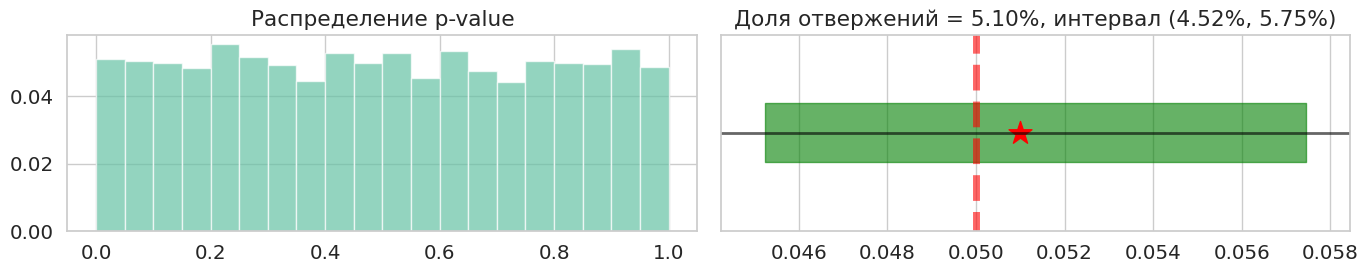

(0.051, (0.04523938710267116, 0.05745000924399014))

In [18]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y, cuped=False, num_buckets=10),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=n_iter,
)

с CUPED

  0%|          | 0/5000 [00:00<?, ?it/s]

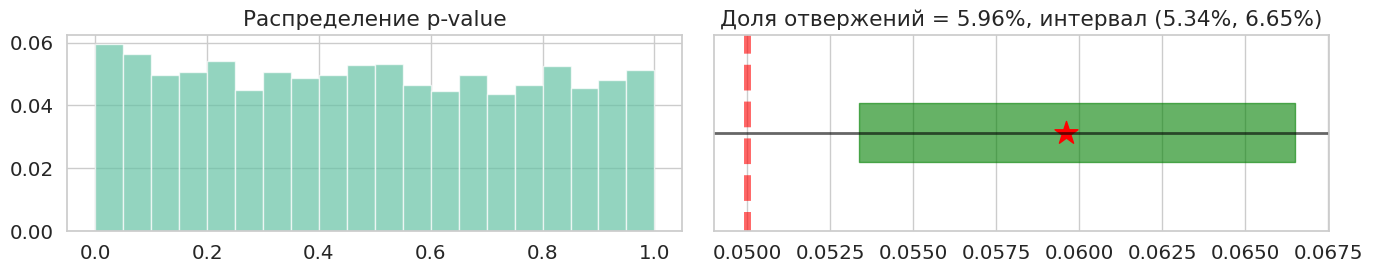

(0.0596, (0.05336981270225661, 0.06650637917094973))

In [19]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y, cuped=True, num_buckets=10),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=n_iter,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

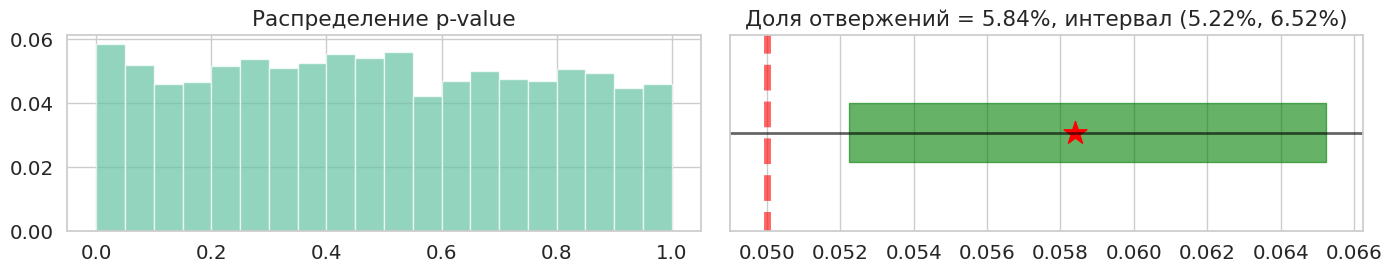

(0.0584, (0.05223283299055026, 0.0652452013673242))

In [20]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y, cuped=True, num_buckets=20),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=n_iter,
)

Для какого количества бакетов выполнены одновременно первые два условия из перечисленных вначале задачи?

Для 10 бакетов без CUPED

**3.** Если такие случаи нашлись, оцени мощность соответствующих тестов для размеров эффекта от 1% до 5%. Сравни ее с CUPED в методе линеаризации.

*Хм, кажется, или здесь тоже только код позапускать?*

Провалидируем для 20 бакетов с CUPED, так как почти поддерживается ошибка первого рода

In [9]:
def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users

def cuped_transform(
    x_data,
    y_data,
    sample_name="pilot",
    cuped_name="cuped",
    covariate_name="prepilot",
    paired=False,
    return_theta=False,
):
    """
    Выполняет CUPED-преобразование.

    :param x_data, y_data: данные по двум группам
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    """

    # Случай парных выборок
    if paired:
        theta = (
            np.cov(
                x_data[covariate_name] - y_data[covariate_name],
                x_data[sample_name] - y_data[sample_name],
            )[0, 1]
        ) / ((x_data[covariate_name] - y_data[covariate_name]).var(ddof=0))

    # Случай независимых выборок
    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1]
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0)
            + y_data[covariate_name].var(ddof=0)
        )

    # Делаем преобразование
    x_data[cuped_name] = x_data[sample_name] - theta * x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta * y_data[covariate_name]

    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data
    
def linearization_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "linearization_values_cuped" if cuped else "linearization_values"

    # Линеаризация на экспериментальном периоде
    control_users_pilot, test_users_pilot = linearization(
        control_data[control_data["period"] == 1],
        test_data[test_data["period"] == 1],
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    if cuped:
        # Линеаризация на предэкспериментальном периоде
        control_users_prepilot, test_users_prepilot = linearization(
            control_data[control_data["period"] == 0],
            test_data[test_data["period"] == 0],
            numerator_name=numerator_name,
            denominator_name=denominator_name,
            user_name=user_name,
            eta=eta,
        )

        # Соединяем две таблицы данных для каждой из групп
        control_users_pilot = control_users_pilot.join(
            control_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )
        test_users_pilot = test_users_pilot.join(
            test_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )

        # Сделаем cuped-преобразование
        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="linearization_values",
            cuped_name=name,
            covariate_name="linearization_values_prepilot",
        )

    else:
        # Если не делаем CUPED, то используем сами линеаризованные данные
        control_data, test_data = control_users_pilot, test_users_pilot

    # Применяем t-test для линеаризованной метрики
    res = sps.ttest_ind(test_data[name], control_data[name])
    stat = res.statistic
    pvalue = res.pvalue

    # дов. интервал линеаризованной метрики
    left_bound, right_bound = res.confidence_interval()

    # по теореме с занятия дов. интервал исходной метрики
    # пропорционален линеаризованной метрике
    coef = eta * control_data[denom].mean() + (1 - eta) * test_data[denom].mean()
    left_bound /= coef
    right_bound /= coef

    return stat, pvalue, left_bound, right_bound

def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    # Генерируем выборки
    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    # Добавляем эффект, если хотим оценить мощность
    if relative_effect:
        test_data[feature_values] *= 1 + effect * (test_data["period"] == 1)
    else:
        test_data[feature_values] += effect * (test_data["period"] == 1)

    # Применяем критерий
    return test(control_data, test_data)[1]



def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals=show_pvals,
            pvals=pvals,
            alpha=alpha,
            figsize=figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

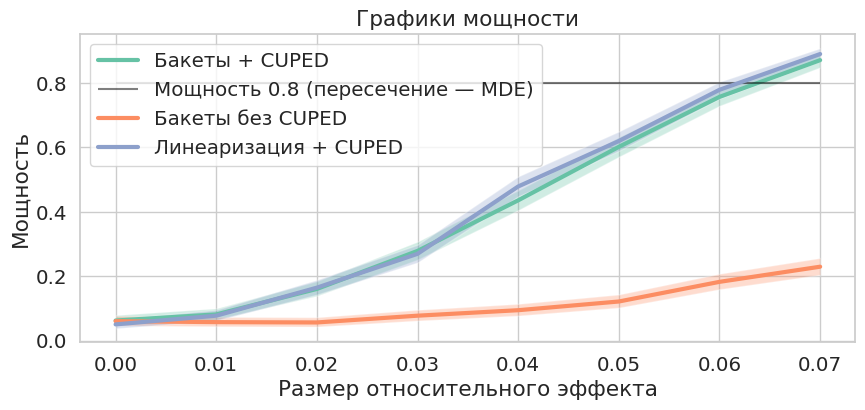

In [11]:
effects_list = np.arange(0, 0.07, 0.01)
powers = np.zeros(len(effects_list))
left_bounds = np.zeros(len(effects_list))
right_bounds = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
        test=lambda x, y: bucket_ratio_ttest(x, y, cuped=True, num_buckets=20),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=1000,
        draw=False,
    )

draw_power(
    powers,
    left_bounds,
    right_bounds,
    label="Бакеты + CUPED",
    new_figure=True,
    effects_list=effects_list,
)

powers_buckets_no_cuped = np.zeros(len(effects_list))
left_bounds_buckets_no_cuped = np.zeros(len(effects_list))
right_bounds_buckets_no_cuped = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers_buckets_no_cuped[i], (left_bounds_buckets_no_cuped[i], right_bounds_buckets_no_cuped[i]) = run_experiments(
        test=lambda x, y: bucket_ratio_ttest(x, y, cuped=False, num_buckets=20),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=1000,
        draw=False,
    )

draw_power(
    powers_buckets_no_cuped,
    left_bounds_buckets_no_cuped,
    right_bounds_buckets_no_cuped,
    label="Бакеты без CUPED",
    new_figure=False,
    effects_list=effects_list,
)

powers_linear = np.zeros(len(effects_list))
left_bounds_linear = np.zeros(len(effects_list))
right_bounds_linear = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers_linear[i], (left_bounds_linear[i], right_bounds_linear[i]) = run_experiments(
        test=lambda x, y: linearization_ratio_ttest(x, y, cuped=True, eta=0.5),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=1000,
        draw=False,
    )

draw_power(
    powers_linear,
    left_bounds_linear,
    right_bounds_linear,
    label="Линеаризация + CUPED",
    new_figure=False,
    effects_list=effects_list,
)


**Выводы:** В задаче был применен визуальный анализ для ratio-метрик. После того, как было найдено количество бакетов проходящее визуальный тест на сонаправленность был стандартно исследован метод бакеты+CUPED.

Вот и первая задачка закончилась! Правда же простая и интересная задачка?)

**Ответ:** как всегда

---

### Задача 2.

Нам показалось, что задач очень мало, ведь тут столько всего интересного, хотя мы представили твою реакцию :)

Итак, вот еще одна задачка, но она *короткая и очень простая*, честно-честно. На лекции была получена связь между разницей линеаризованной метрики $\Delta L$ и исходной ratio-метрики $\Delta R$. Это соотношение позволяет в методе линеаризации получать доверительный интервал эффекта по исходной ratio-метрики так, как показано в ноутбуке с занятия. И на занятии мы даже проверили корректность такого подхода с точки зрения вероятности ошибки I рода и мощности.

Однако, давай проверим, насколько таким интервалом можно оценить истинный эффект. Для этого можно использовать следующие показатели качества:
* доля покрытия интервалом истинного значения параметра,
* средняя длина доверительного интервала.

Например, в первом случае нужно сравнить интервал не с нулем, как в ноутбуке, а с непосредственно истинным значением эффекта. Во втором случае &mdash; просто взять разность границ интервалов и усреднить.



Возьми с занятия код функции `run_experiments` и модифицируй ее так, чтобы после итераций оставались только границы доверительных интервалов. Далее посчитай указанные выше показатели качества. Это можно сделать внутри функции, а можно попросить ее вернуть список всех интервалов и все посчитать уже после.

Выполни это со следующими тестами:
* линеаризация,
* линеаризация + CUPED,
* дельта-метод.

*Ты же понимаешь, что по сути нужно выполнить ровно те же итерации, только брать не p-value, а доверительный интервал? Внутри функции даже всю визуализацию можно убрать.*

*Указания*:
* Учти, что в реализации теста через дельта-метод мы не фильтровали данные по периоду. Если ты берешь генерацию данных с периодами, не забудь сделать фильтрацию.
* Для интерпретации можно использовать как абсолютные, так и относительные эффекты при генерации данных. Однако, линеаризация не совместима с относительным тестом, потому как линеаризованная метрика может принимать разные знаки. Поэтому оценивать нужно только абсолютные эффекты. Если на генерации использовали относительные, не забудьте их перевести в абсолютные при сравнении интервалов.
* Сделай сравнение как для маленьких, так и для больших эффектов. Из теоремы с лекции мы помним, что для больших эффектов линеаризованная метрика может отклоняться от показателей исходной ratio-метрики.

In [33]:
def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    test_data[feature_values] += effect * (test_data["period"] == 1)

    # Применяем критерий
    test_res = test(control_data, test_data)
    left_bound = test_res[2]
    right_bound = test_res[3]
    return left_bound, right_bound


def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    bounds = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    bounds = np.array(bounds).reshape(-1, 2)

    return bounds, np.mean(bounds[:, 1] - bounds[:, 0])

In [34]:
def delta_test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    test_data[feature_values] -= effect

    # Применяем критерий
    test_res = test(control_data, test_data)
    left_bound = test_res[2]
    right_bound = test_res[3]
    return left_bound, right_bound


def delta_run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    bounds = Parallel(n_jobs=n_jobs)(
        delayed(delta_test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    bounds = np.array(bounds).reshape(-1, 2)

    return bounds, np.mean(bounds[:, 1] - bounds[:, 0])

In [35]:
def relative_var(mean1, mean2, var1, var2, cov):
    """Формула дисперсии относительного t-test"""

    return (
        var1 / mean2**2
        + var2 * mean1**2 / mean2**4
        - 2 * cov * mean1 / mean2**3
    )
def ratio_var(data, numerator_name, denominator_name, user_name):
    '''
    Оценка асимптотической дисперсии ratio-метрики.
    
    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    '''
    
    user_sums = data.groupby(user_name).sum()
    
    mean1, mean2 = user_sums.mean().loc[[numerator_name, denominator_name]]
    var1, var2 = user_sums.var().loc[[numerator_name, denominator_name]] / len(user_sums)
    cov = user_sums.cov().loc[numerator_name, denominator_name] / len(user_sums)
    
    return relative_var(mean1, mean2, var1, var2, cov)
def delta_ratio_ttest(
    x_data, y_data, 
    numerator_name='session_lengths', 
    denominator_name=None, 
    user_name='user_id',
    alpha=0.05
):
    '''
    Реализаця t-test для ratio-метрики через ее асимптотическую дисперсию, 
    полученную с помощью дельта-метода.
    
    Аргументы:
    x_data, y_data -- выборки одинакового размера
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    alpha -- уровень значимости
    
    Возвращает:
    stat -- статистика критерия
    left_bound, right_bound -- границы дов. интервала
    pvalue
    '''
    
    if denominator_name is None:
        denominator_name = 'ratio_denominator'
        x_data[denominator_name] = 1
        y_data[denominator_name] = 1
        
    # Оценка мат. ожиданий ratio-метрик
    x_mean = ratio_metric(x_data, numerator_name, denominator_name)
    y_mean = ratio_metric(y_data, numerator_name, denominator_name)
    
    # Оценка дисперсий ratio-метрик
    x_var = ratio_var(x_data, numerator_name, denominator_name, user_name=user_name)
    y_var = ratio_var(y_data, numerator_name, denominator_name, user_name=user_name)
    
    # Далее формируем обычный t-test
    stat = x_mean - y_mean
    var = x_var + y_var
    std = np.sqrt(var)
    
    z_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(z_stat))
    
    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std
    right_bound = stat + q*std
    
    return stat, pvalue, left_bound, right_bound


In [36]:
def linearization_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "linearization_values_cuped" if cuped else "linearization_values"

    # Линеаризация на экспериментальном периоде
    control_users_pilot, test_users_pilot = linearization(
        control_data[control_data["period"] == 1],
        test_data[test_data["period"] == 1],
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    if cuped:
        # Линеаризация на предэкспериментальном периоде
        control_users_prepilot, test_users_prepilot = linearization(
            control_data[control_data["period"] == 0],
            test_data[test_data["period"] == 0],
            numerator_name=numerator_name,
            denominator_name=denominator_name,
            user_name=user_name,
            eta=eta,
        )

        # Соединяем две таблицы данных для каждой из групп
        control_users_pilot = control_users_pilot.join(
            control_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )
        test_users_pilot = test_users_pilot.join(
            test_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )

        # Сделаем cuped-преобразование
        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="linearization_values",
            cuped_name=name,
            covariate_name="linearization_values_prepilot",
        )

    else:
        # Если не делаем CUPED, то используем сами линеаризованные данные
        control_data, test_data = control_users_pilot, test_users_pilot

    # Применяем t-test для линеаризованной метрики
    res = sps.ttest_ind(test_data[name], control_data[name])
    stat = res.statistic
    pvalue = res.pvalue

    # дов. интервал линеаризованной метрики
    left_bound, right_bound = res.confidence_interval()

    # по теореме с занятия дов. интервал исходной метрики
    # пропорционален линеаризованной метрике
    coef = eta * control_data[denom].mean() + (1 - eta) * test_data[denom].mean()
    left_bound /= coef
    right_bound /= coef

    return stat, pvalue, left_bound, right_bound

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

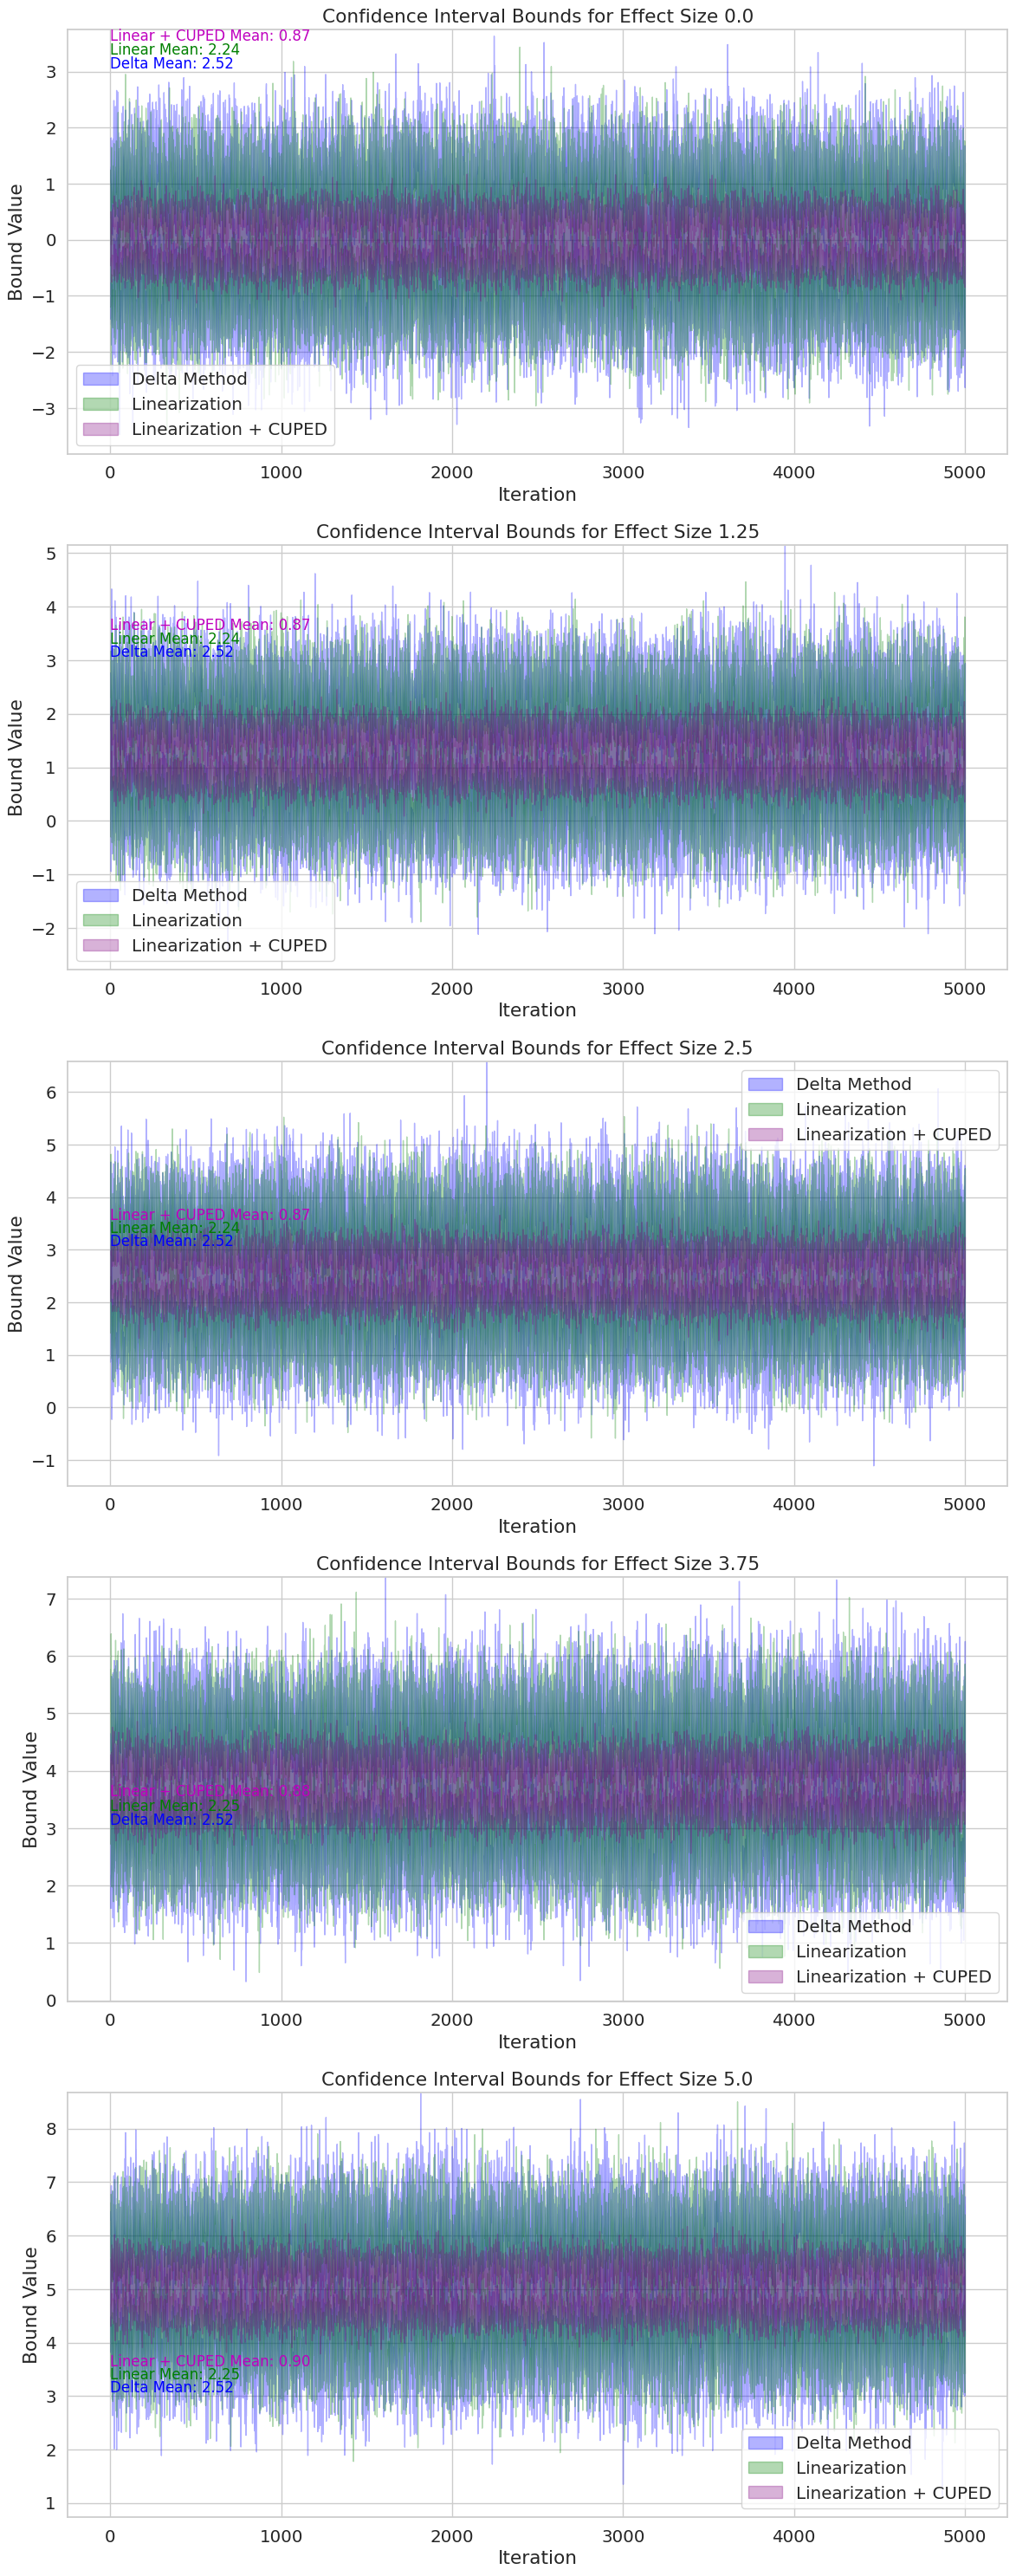

In [37]:
import numpy as np
import matplotlib.pyplot as plt

effects_list = np.linspace(0, 5, 5)

fig, axes = plt.subplots(len(effects_list), 1, figsize=(12, 6 * len(effects_list)))

for idx, effect in enumerate(effects_list):
    
    delta_bounds, delta_mean = delta_run_experiments(
        test=delta_ratio_ttest,
        generate_sample_control=lambda size: generate_session_sample(size),
        sample_size=sample_size,
        n_iter=n_iter,
        effect=effect,
    )

    linear_bounds, linear_mean = run_experiments(
        test=lambda x, y: linearization_ratio_ttest(x, y, cuped=False, eta=0.5),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        sample_size=sample_size,
        n_iter=n_iter,
        effect=effect,
    )

    linear_cuped_bounds, linear_cuped_mean = run_experiments(
        test=lambda x, y: linearization_ratio_ttest(x, y, cuped=True, eta=0.5),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        sample_size=sample_size,
        n_iter=n_iter,
        effect=effect,
    )

    ax = axes[idx]  # Выбираем текущий подграфик

    ax.fill_between(range(len(delta_bounds)), delta_bounds[:, 0], delta_bounds[:, 1], alpha=0.3, label='Delta Method', color='blue')
    ax.fill_between(range(len(linear_bounds)), linear_bounds[:, 0], linear_bounds[:, 1], alpha=0.3, label='Linearization', color='green')
    ax.fill_between(range(len(linear_cuped_bounds)), linear_cuped_bounds[:, 0], linear_cuped_bounds[:, 1], alpha=0.3, label='Linearization + CUPED', color='purple')

    # ax.axhline(y=effect, color='r', linestyle='-', label='True Effect')

    # Добавляем текст с результатами
    ax.text(0, 3, f'Delta Mean: {delta_mean:.2f}', color='b', fontsize=12, verticalalignment='bottom')
    ax.text(0, 3.25, f'Linear Mean: {linear_mean:.2f}', color='g', fontsize=12, verticalalignment='bottom')
    ax.text(0, 3.5, f'Linear + CUPED Mean: {linear_cuped_mean:.2f}', color='m', fontsize=12, verticalalignment='bottom')

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Bound Value')
    ax.set_title(f'Confidence Interval Bounds for Effect Size {effect}')
    ax.legend()
    ax.set_ylim([None, max(3.75, delta_bounds[:, 1].max())])

plt.tight_layout()  # Подгоняем расстояния между подграфиками
plt.show()


Теперь просто визуализируй полученные значения, сравни интервалы и сделай выводы.

Визуализация выше

**Выводы**

Как видим, с увеличением эффекта немного возрастате средняя длина интервала

Также заметим, линереазиция+CUPED имеет интервал ужже, чем в случае delta метода и линеаризации.

Правда простая задача?)

---

### Задача 3.

Отлично, впереди все самое интересное &mdash; реальные данные! Вспомни, ранее мы делали дизайн АБ-теста на сайте Физтех.Статистики, причем в качестве метрики использовали среднюю по посетителям глубину просмотра страниц. Однако, на практике заказчики чаще интересуются глубиной просмотра страниц в среднем по всем посетителям сразу. Эту метрику мы и рассмотрим в данной задаче.

Поясни, почему она является ratio-метриками, и укажи, что в числителе, а что в знаменателе.

Аналогично рассмотри метрику длительности веб-сессий по всему сайту.

Она является ratio-метрикой, так как это отношение количества посещенных страниц у пользователя (числитель) к количеству пользователей(знаменатель).

По той же причине, длительность по сайту является ratio-метрикой, так как является отношением длительности сессий(числитель) к общему числу сессий(знаменатель).

**1.** Хм, а если это ratio-метрики, правильно ли мы с ними работали? Давай проверим сонаправленность на реальных данных. Проверку нужно выполнить аналогично AA-тесту, совершая следующие итерации.
1. Выбрать случайный интервал времени фиксированной длины в истории визитов.
2. Выбрать две случайные группы фиксированного размера.
3. Посчитать по ним ratio-метрику и исследуемую метрику.

*Правда ведь просто? Ну разве что выбор момента времени и группы надо дописать.*

Проведи эту проверку для длительности и глубины (можно в одном цикле) для следующих подходов:
- агрегация данных по пользователям,
- метод бакетов,
- линеаризация.

Все эти способы рассматривались на занятии, так что это еще один повод туда заглянуть. Напомним, ratio-метрика считается как общее отношение, без агрегации по пользователям.

Выполни всю эту процедуру для двух разных размеров групп и двух разных длин интервалов. Например, 10% и 20% пользователей, а так же 3 и 5 недель.

In [3]:
data = pd.read_csv(
    "miptstats_metrica.tsv",
    sep="\t",
)
data["ym:s:dateTimeUTC"] = pd.to_datetime(data["ym:s:dateTimeUTC"])
data = data[["ym:s:clientID", "ym:s:dateTimeUTC", "ym:s:pageViews", "ym:s:visitDuration"]]
data.head()

ym:s:clientID    ym:s:dateTimeUTC  ym:s:pageViews  ym:s:visitDuration
0  1568056026568729022 2020-01-01 03:28:50               1                   1
1  1577864187752491163 2020-01-01 10:36:27               9                 215
2  1567765219104836417 2020-01-01 11:40:44               2                  88
3  1576839432510419026 2020-01-01 11:50:13               1                  19
4  1576246599115183097 2020-01-01 12:17:33               2                   2

In [4]:
END_DATE = data["ym:s:dateTimeUTC"].max()
START_DATE = data["ym:s:dateTimeUTC"].min()

END_DATE

Timestamp('2024-02-25 23:58:46')

In [5]:
def experiment_func_agreg_by_user(data, fraction_of_clients, duration_weeks, n_iter):
    values_absolute_deep = []
    values_absolute_duration = []
    values_ratio_absolute_deep = []
    values_ratio_absolute_duration = []

    values_relative_deep = []
    values_relative_duration = []
    values_ratio_relative_duration = []
    values_ratio_relative_deep = []

    for _ in tqdm(range(n_iter)):
        time_delta_days = (END_DATE - START_DATE).days - duration_weeks * 7
        random_days = np.random.randint(0, time_delta_days) if time_delta_days > 0 else 0
        random_date = START_DATE + pd.DateOffset(days=random_days)
        end_date = random_date + pd.DateOffset(weeks=duration_weeks)
        
        # Filter data for the selected date range
        tmp_data = data[(data["ym:s:dateTimeUTC"] >= random_date) & (data["ym:s:dateTimeUTC"] <= end_date)]
        
        # Select a random fraction of clients
        clients = tmp_data["ym:s:clientID"].unique()
        selected_clients = np.random.choice(clients, size=int(len(clients) * fraction_of_clients), replace=False)

        np.random.shuffle(selected_clients)
        group_1_clients = selected_clients[:len(selected_clients) // 2]
        group_2_clients = selected_clients[len(selected_clients) // 2:]
        
        group_1_data = tmp_data[tmp_data["ym:s:clientID"].isin(group_1_clients)]
        group_2_data = tmp_data[tmp_data["ym:s:clientID"].isin(group_2_clients)]

        ratio_metric_deep_val_1 = ratio_metric(group_1_data, numerator_name="ym:s:pageViews")
        ratio_metric_duration_val_1 = ratio_metric(group_1_data, numerator_name="ym:s:visitDuration")

        our_metric_deep_1 = group_1_data.groupby("ym:s:clientID")["ym:s:pageViews"].mean().mean()
        our_metric_duration_1 = group_1_data.groupby("ym:s:clientID")["ym:s:visitDuration"].mean().mean()

        ratio_metric_deep_val_2 = ratio_metric(group_2_data, numerator_name="ym:s:pageViews")
        ratio_metric_duration_val_2 = ratio_metric(group_2_data, numerator_name="ym:s:visitDuration")

        our_metric_deep_2 = group_2_data.groupby("ym:s:clientID")["ym:s:pageViews"].mean().mean()
        our_metric_duration_2 = group_2_data.groupby("ym:s:clientID")["ym:s:visitDuration"].mean().mean()

        values_absolute_deep.append(our_metric_deep_1 - our_metric_deep_2)
        values_absolute_duration.append(our_metric_duration_1 - our_metric_duration_2)
        values_ratio_absolute_deep.append(ratio_metric_deep_val_1 - ratio_metric_deep_val_2)
        values_ratio_absolute_duration.append(ratio_metric_duration_val_1 - ratio_metric_duration_val_2)

        values_relative_deep.append((our_metric_deep_1 - our_metric_deep_2) / our_metric_deep_2)
        values_relative_duration.append((our_metric_duration_1 - our_metric_duration_2) / our_metric_duration_2)
        values_ratio_relative_duration.append((ratio_metric_duration_val_1 - ratio_metric_duration_val_2) / ratio_metric_duration_val_2)
        values_ratio_relative_deep.append((ratio_metric_deep_val_1 - ratio_metric_deep_val_2) / ratio_metric_deep_val_2)

    return (
        values_absolute_deep,
        values_absolute_duration,
        values_ratio_absolute_deep,
        values_ratio_absolute_duration,
        values_relative_deep,
        values_relative_duration,
        values_ratio_relative_deep,
        values_ratio_relative_duration,
    )


In [6]:
def experiment_func_agreg_by_bucket(data, fraction_of_clients, duration_weeks, n_iter, num_buckets=10):
    values_absolute_deep = []
    values_absolute_duration = []
    values_ratio_absolute_deep = []
    values_ratio_absolute_duration = []

    values_relative_deep = []
    values_relative_duration = []
    values_ratio_relative_duration = []
    values_ratio_relative_deep = []

    for _ in tqdm(range(n_iter)):
        time_delta_days = (END_DATE - START_DATE).days - duration_weeks * 7
        random_days = np.random.randint(0, time_delta_days) if time_delta_days > 0 else 0
        random_date = START_DATE + pd.DateOffset(days=random_days)
        end_date = random_date + pd.DateOffset(weeks=duration_weeks)
        
        # Фильтруем данные по выбранному временному диапазону
        tmp_data = data[(data["ym:s:dateTimeUTC"] >= random_date) & (data["ym:s:dateTimeUTC"] <= end_date)]
        
        # Выбираем случайную долю клиентов
        clients = tmp_data["ym:s:clientID"].unique()
        selected_clients = np.random.choice(clients, size=int(len(clients) * fraction_of_clients), replace=False)

        # Разбиваем отобранных клиентов на бакеты
        client_buckets = {client: hash(client) % num_buckets for client in selected_clients}
        bucket_df = pd.DataFrame(list(client_buckets.items()), columns=["ym:s:clientID", "bucket"])
        
        # Добавляем информацию о бакете в tmp_data
        tmp_data = tmp_data.merge(bucket_df, on="ym:s:clientID", how="left")
        
        # Разделяем бакеты на две группы
        sorted_buckets = sorted(bucket_df["bucket"].unique())  # Получаем отсортированные номера бакетов
        half = len(sorted_buckets) // 2
        group_1_buckets = sorted_buckets[:half]  # Первая половина бакетов
        group_2_buckets = sorted_buckets[half:]  # Вторая половина

        # Формируем группы клиентов по бакетам
        group_1_data = tmp_data[tmp_data["bucket"].isin(group_1_buckets)]
        group_2_data = tmp_data[tmp_data["bucket"].isin(group_2_buckets)]

        ratio_metric_deep_val_1 = ratio_metric(group_1_data, numerator_name="ym:s:pageViews")
        ratio_metric_duration_val_1 = ratio_metric(group_1_data, numerator_name="ym:s:visitDuration")

        # Пересчитываем по бакетам, а потом берем среднее
        our_metric_deep_1 = group_1_data.groupby("bucket")["ym:s:pageViews"].mean().mean()
        our_metric_duration_1 = group_1_data.groupby("bucket")["ym:s:visitDuration"].mean().mean()

        ratio_metric_deep_val_2 = ratio_metric(group_2_data, numerator_name="ym:s:pageViews")
        ratio_metric_duration_val_2 = ratio_metric(group_2_data, numerator_name="ym:s:visitDuration")

        # Пересчитываем по бакетам, а потом берем среднее
        our_metric_deep_2 = group_2_data.groupby("bucket")["ym:s:pageViews"].mean().mean()
        our_metric_duration_2 = group_2_data.groupby("bucket")["ym:s:visitDuration"].mean().mean()

        values_absolute_deep.append(our_metric_deep_1 - our_metric_deep_2)
        values_absolute_duration.append(our_metric_duration_1 - our_metric_duration_2)
        values_ratio_absolute_deep.append(ratio_metric_deep_val_1 - ratio_metric_deep_val_2)
        values_ratio_absolute_duration.append(ratio_metric_duration_val_1 - ratio_metric_duration_val_2)

        values_relative_deep.append((our_metric_deep_1 - our_metric_deep_2) / our_metric_deep_2)
        values_relative_duration.append((our_metric_duration_1 - our_metric_duration_2) / our_metric_duration_2)
        values_ratio_relative_duration.append((ratio_metric_duration_val_1 - ratio_metric_duration_val_2) / ratio_metric_duration_val_2)
        values_ratio_relative_deep.append((ratio_metric_deep_val_1 - ratio_metric_deep_val_2) / ratio_metric_deep_val_2)

    return (
        values_absolute_deep,
        values_absolute_duration,
        values_ratio_absolute_deep,
        values_ratio_absolute_duration,
        values_relative_deep,
        values_relative_duration,
        values_ratio_relative_deep,
        values_ratio_relative_duration,
    )

In [7]:
def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users


In [8]:
def experiment_func_agreg_by_linearization(
    data, fraction_of_clients, duration_weeks, n_iter, eta=0
):
    values_absolute_deep = []
    values_absolute_duration = []
    values_ratio_absolute_deep = []
    values_ratio_absolute_duration = []

    values_relative_deep = []
    values_relative_duration = []
    values_ratio_relative_duration = []
    values_ratio_relative_deep = []

    for _ in tqdm(range(n_iter)):
        time_delta_days = (END_DATE - START_DATE).days - duration_weeks * 7
        random_days = (
            np.random.randint(0, time_delta_days) if time_delta_days > 0 else 0
        )
        random_date = START_DATE + pd.DateOffset(days=random_days)
        end_date = random_date + pd.DateOffset(weeks=duration_weeks)

        # Filter data for the selected date range
        tmp_data = data[
            (data["ym:s:dateTimeUTC"] >= random_date)
            & (data["ym:s:dateTimeUTC"] <= end_date)
        ]

        # Select a random fraction of clients
        clients = tmp_data["ym:s:clientID"].unique()
        selected_clients = np.random.choice(
            clients, size=int(len(clients) * fraction_of_clients), replace=False
        )

        np.random.shuffle(selected_clients)
        group_1_clients = selected_clients[: len(selected_clients) // 2]
        group_2_clients = selected_clients[len(selected_clients) // 2 :]

        group_1_data = tmp_data[tmp_data["ym:s:clientID"].isin(group_1_clients)]
        group_2_data = tmp_data[tmp_data["ym:s:clientID"].isin(group_2_clients)]

        # Глубина (pageViews)
        ratio_metric_deep_val_1 = ratio_metric(
            group_1_data, numerator_name="ym:s:pageViews"
        )
        ratio_metric_deep_val_2 = ratio_metric(
            group_2_data, numerator_name="ym:s:pageViews"
        )

        # Продолжительность (visitDuration)
        ratio_metric_duration_val_1 = ratio_metric(
            group_1_data, numerator_name="ym:s:visitDuration"
        )
        ratio_metric_duration_val_2 = ratio_metric(
            group_2_data, numerator_name="ym:s:visitDuration"
        )

        # Apply linearization to pageViews and visitDuration separately for both groups
        control_data = group_1_data.copy()
        test_data = group_2_data.copy()

        # Преобразуем datetime в числовые значения
        datetime_columns = control_data.select_dtypes(include=[np.datetime64]).columns
        control_data[datetime_columns] = control_data[datetime_columns].apply(
            pd.to_numeric, errors="coerce"
        )
        test_data[datetime_columns] = test_data[datetime_columns].apply(
            pd.to_numeric, errors="coerce"
        )

        # Применяем линеаризацию для глубины (pageViews)
        control_users, test_users = linearization(
            control_data,
            test_data,
            numerator_name="ym:s:pageViews",
            denominator_name="ym:s:visitDuration",  # Сохраняем эту метрику для линеаризации
            user_name="ym:s:clientID",
            eta=eta,
        )

        values_absolute_deep.append(
            control_users["linearization_values"].mean()
            - test_users["linearization_values"].mean()
        )
        values_relative_deep.append(
            (
                control_users["linearization_values"].mean()
                - test_users["linearization_values"].mean()
            )
            / test_users["linearization_values"].mean()
        )
        values_ratio_absolute_deep.append(
            ratio_metric_deep_val_1 - ratio_metric_deep_val_2
        )
        values_ratio_relative_deep.append(
            (ratio_metric_deep_val_1 - ratio_metric_deep_val_2) / ratio_metric_deep_val_2
        )

        # Применяем линеаризацию для продолжительности (visitDuration)
        control_users, test_users = linearization(
            control_data,
            test_data,
            numerator_name="ym:s:visitDuration",
            denominator_name="ym:s:pageViews",  # Сохраняем эту метрику для линеаризации
            user_name="ym:s:clientID",
            eta=eta,
        )

        values_absolute_duration.append(
            control_users["linearization_values"].mean()
            - test_users["linearization_values"].mean()
        )
        values_relative_duration.append(
            (
                control_users["linearization_values"].mean()
                - test_users["linearization_values"].mean()
            )
            / test_users["linearization_values"].mean()
        )
        values_ratio_absolute_duration.append(
            ratio_metric_duration_val_1 - ratio_metric_duration_val_2
        )
        values_ratio_relative_duration.append(
            (ratio_metric_duration_val_1 - ratio_metric_duration_val_2) / ratio_metric_duration_val_2
        )

    return (
        values_absolute_deep,
        values_absolute_duration,
        values_ratio_absolute_deep,
        values_ratio_absolute_duration,
        values_relative_deep,
        values_relative_duration,
        values_ratio_relative_deep,
        values_ratio_relative_duration,
    )

Начнем с агрегации по пользователю

  0%|          | 0/5000 [00:00<?, ?it/s]

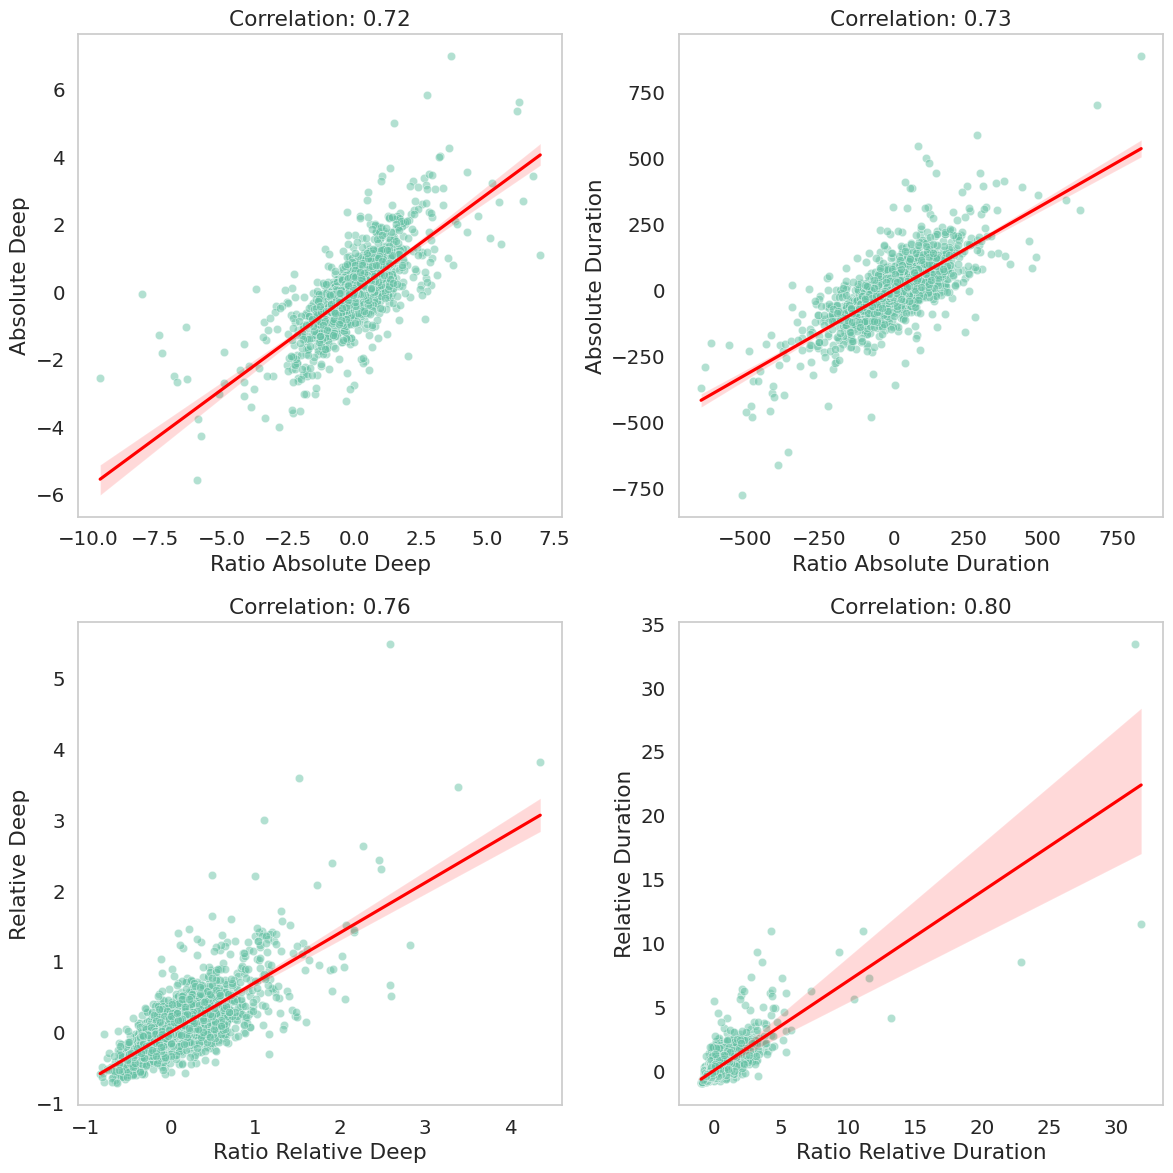

In [47]:
(
    values_absolute_deep,
    values_absolute_duration,
    values_ratio_absolute_deep,
    values_ratio_absolute_duration,
    values_relative_deep,
    values_relative_duration,
    values_ratio_relative_deep,
    values_ratio_relative_duration,
) = experiment_func_agreg_by_user(data, 0.1, 3, n_iter=n_iter)

def plot_all_correlations(data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (x, y, xlabel, ylabel) in enumerate(data):
        row, col = divmod(i, 2)  # Определяем строку и колонку для подграфика
        ax = axes[row, col]
        
        sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax)

        # Линейная регрессия
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax)

        # Корреляция Пирсона
        correlation = np.corrcoef(x, y)[0, 1]
        ax.set_title(f"Correlation: {correlation:.2f}")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

    plt.tight_layout()
    plt.show()

# Данные для построения графиков
info_plot = [
    (values_ratio_absolute_deep, values_absolute_deep, "Ratio Absolute Deep", "Absolute Deep"),
    (values_ratio_absolute_duration, values_absolute_duration, "Ratio Absolute Duration", "Absolute Duration"),
    (values_ratio_relative_deep, values_relative_deep, "Ratio Relative Deep", "Relative Deep"),
    (values_ratio_relative_duration, values_relative_duration, "Ratio Relative Duration", "Relative Duration")
]

plot_all_correlations(info_plot, labels=None)


  0%|          | 0/5000 [00:00<?, ?it/s]

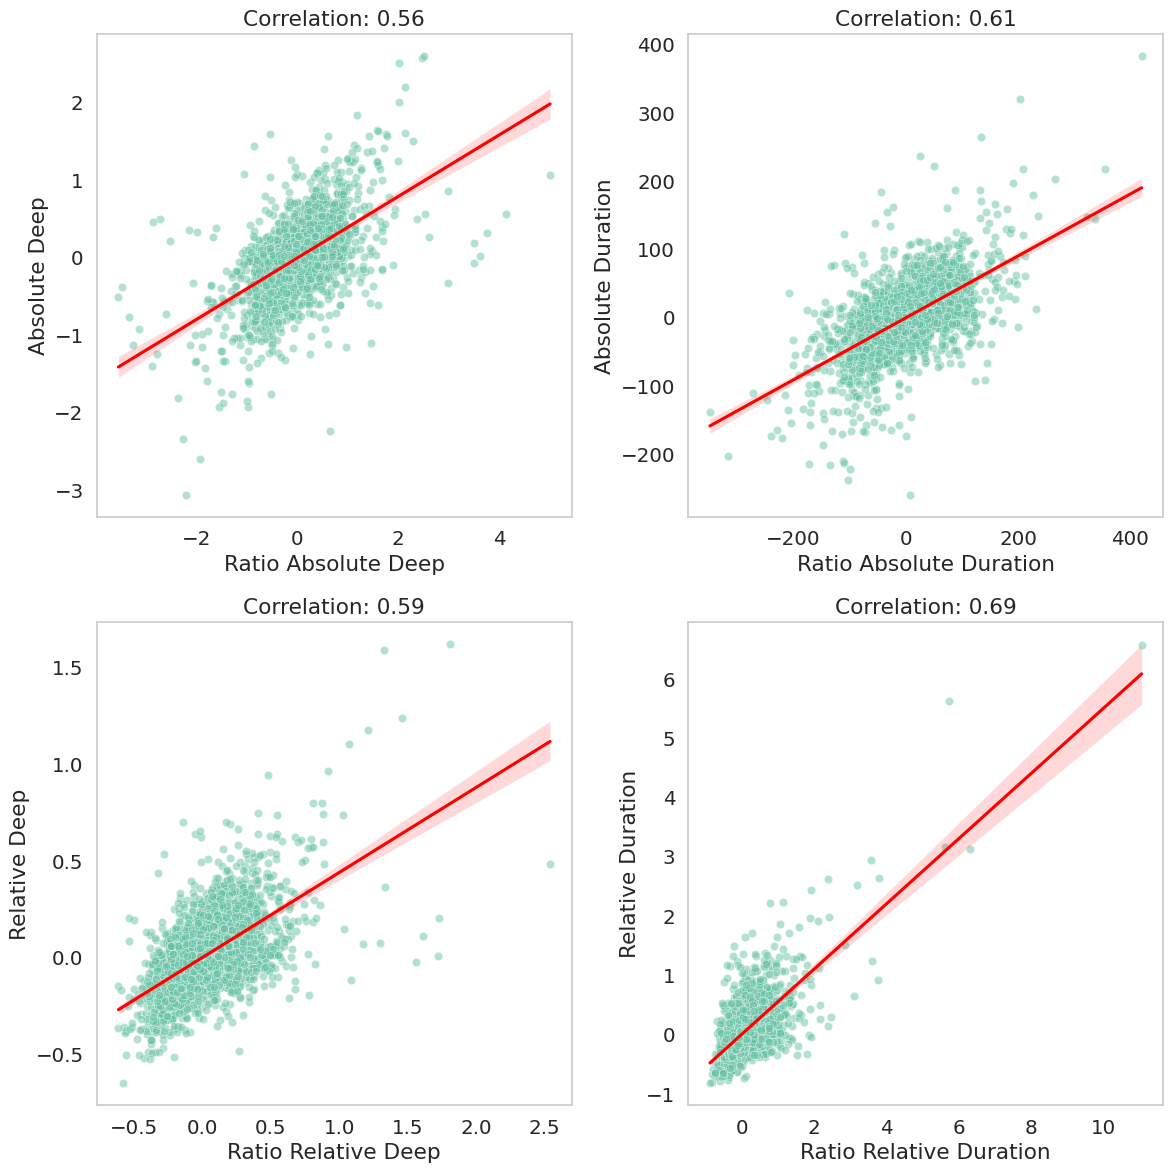

In [48]:
(
    values_absolute_deep,
    values_absolute_duration,
    values_ratio_absolute_deep,
    values_ratio_absolute_duration,
    values_relative_deep,
    values_relative_duration,
    values_ratio_relative_deep,
    values_ratio_relative_duration,
) = experiment_func_agreg_by_user(data, 0.2, 5, n_iter=n_iter)

def plot_all_correlations(data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (x, y, xlabel, ylabel) in enumerate(data):
        row, col = divmod(i, 2)  # Определяем строку и колонку для подграфика
        ax = axes[row, col]
        
        sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax)

        # Линейная регрессия
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax)

        # Корреляция Пирсона
        correlation = np.corrcoef(x, y)[0, 1]
        ax.set_title(f"Correlation: {correlation:.2f}")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

    plt.tight_layout()
    plt.show()

# Данные для построения графиков
info_plot = [
    (values_ratio_absolute_deep, values_absolute_deep, "Ratio Absolute Deep", "Absolute Deep"),
    (values_ratio_absolute_duration, values_absolute_duration, "Ratio Absolute Duration", "Absolute Duration"),
    (values_ratio_relative_deep, values_relative_deep, "Ratio Relative Deep", "Relative Deep"),
    (values_ratio_relative_duration, values_relative_duration, "Ratio Relative Duration", "Relative Duration")
]

plot_all_correlations(info_plot, labels=None)


Сонаправленность не наблюдается

Теперь рассмотрим метод бакетов

  0%|          | 0/5000 [00:00<?, ?it/s]

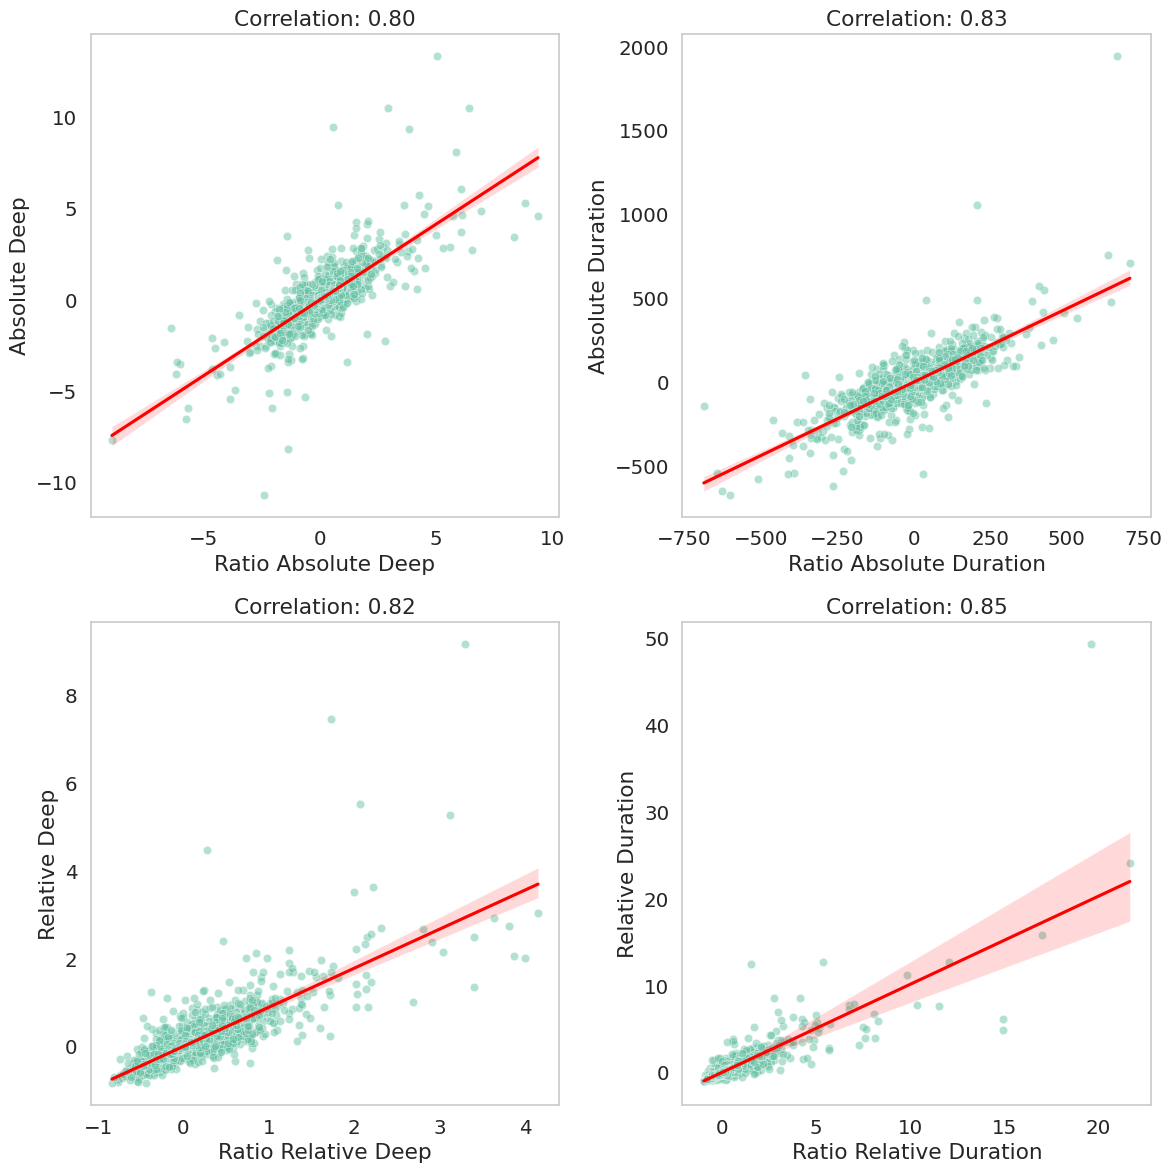

In [49]:
(
    values_absolute_deep,
    values_absolute_duration,
    values_ratio_absolute_deep,
    values_ratio_absolute_duration,
    values_relative_deep,
    values_relative_duration,
    values_ratio_relative_deep,
    values_ratio_relative_duration,
) = experiment_func_agreg_by_bucket(data, 0.1, 3, n_iter=n_iter)

def plot_all_correlations(data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (x, y, xlabel, ylabel) in enumerate(data):
        row, col = divmod(i, 2)  # Определяем строку и колонку для подграфика
        ax = axes[row, col]
        
        sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax)

        # Линейная регрессия
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax)

        # Корреляция Пирсона
        correlation = np.corrcoef(x, y)[0, 1]
        ax.set_title(f"Correlation: {correlation:.2f}")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

    plt.tight_layout()
    plt.show()

# Данные для построения графиков
info_plot = [
    (values_ratio_absolute_deep, values_absolute_deep, "Ratio Absolute Deep", "Absolute Deep"),
    (values_ratio_absolute_duration, values_absolute_duration, "Ratio Absolute Duration", "Absolute Duration"),
    (values_ratio_relative_deep, values_relative_deep, "Ratio Relative Deep", "Relative Deep"),
    (values_ratio_relative_duration, values_relative_duration, "Ratio Relative Duration", "Relative Duration")
]

plot_all_correlations(info_plot, labels=None)


  0%|          | 0/5000 [00:00<?, ?it/s]

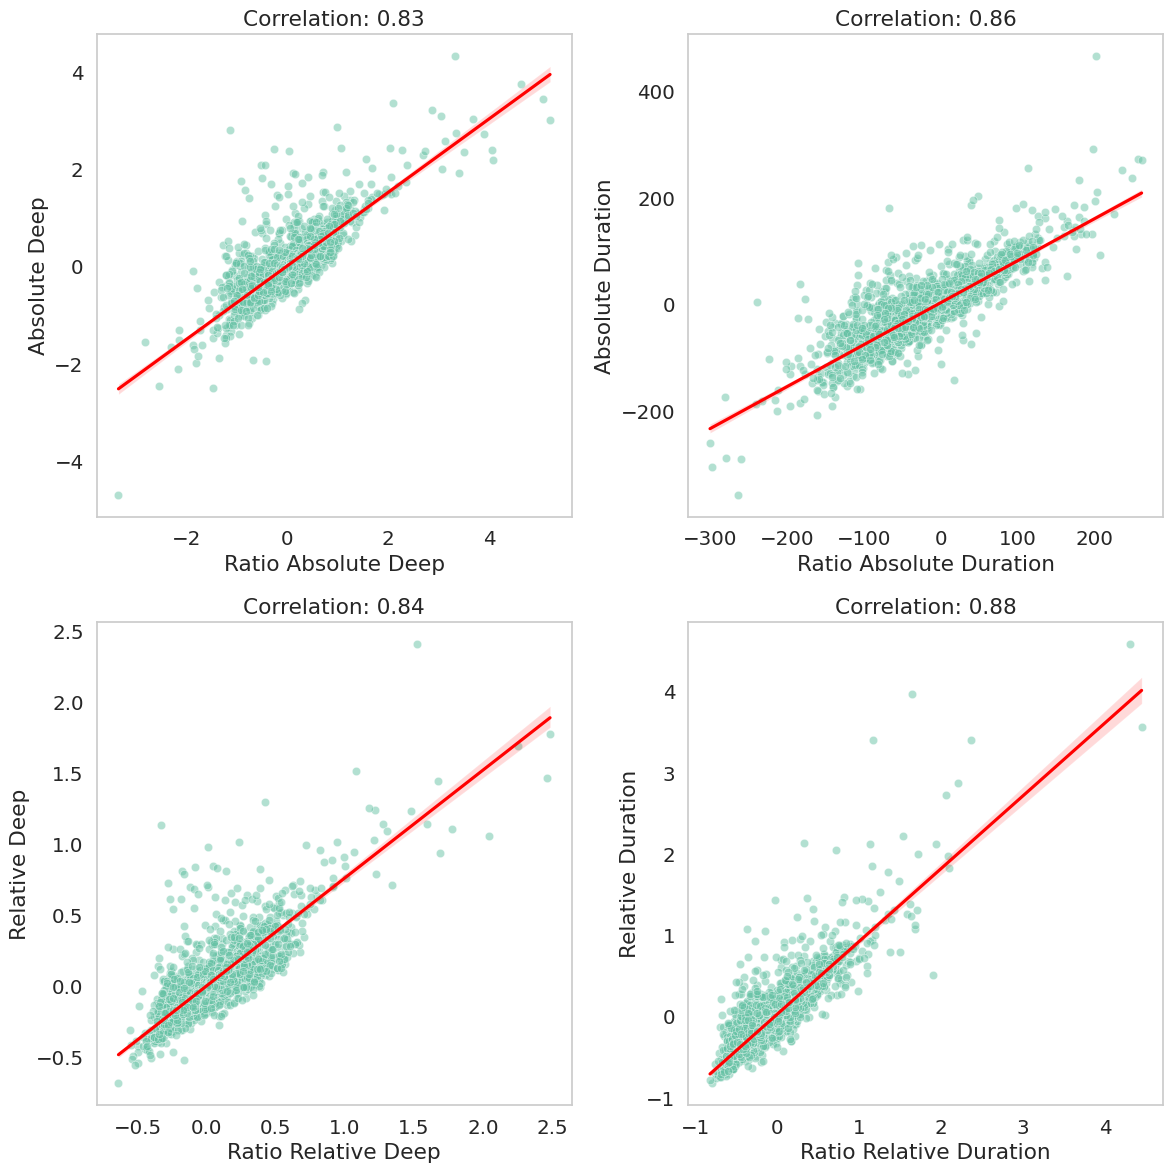

In [50]:
(
    values_absolute_deep,
    values_absolute_duration,
    values_ratio_absolute_deep,
    values_ratio_absolute_duration,
    values_relative_deep,
    values_relative_duration,
    values_ratio_relative_deep,
    values_ratio_relative_duration,
) = experiment_func_agreg_by_bucket(data, 0.2, 5, n_iter=n_iter)

def plot_all_correlations(data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (x, y, xlabel, ylabel) in enumerate(data):
        row, col = divmod(i, 2)  # Определяем строку и колонку для подграфика
        ax = axes[row, col]
        
        sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax)

        # Линейная регрессия
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax)

        # Корреляция Пирсона
        correlation = np.corrcoef(x, y)[0, 1]
        ax.set_title(f"Correlation: {correlation:.2f}")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

    plt.tight_layout()
    plt.show()

# Данные для построения графиков
info_plot = [
    (values_ratio_absolute_deep, values_absolute_deep, "Ratio Absolute Deep", "Absolute Deep"),
    (values_ratio_absolute_duration, values_absolute_duration, "Ratio Absolute Duration", "Absolute Duration"),
    (values_ratio_relative_deep, values_relative_deep, "Ratio Relative Deep", "Relative Deep"),
    (values_ratio_relative_duration, values_relative_duration, "Ratio Relative Duration", "Relative Duration")
]

plot_all_correlations(info_plot, labels=None)


Как видим точки лежат на прямой, но все равно разброс достаточно сильный.

Теперь применим ленаризацию с eta=0.5

  0%|          | 0/5000 [00:00<?, ?it/s]

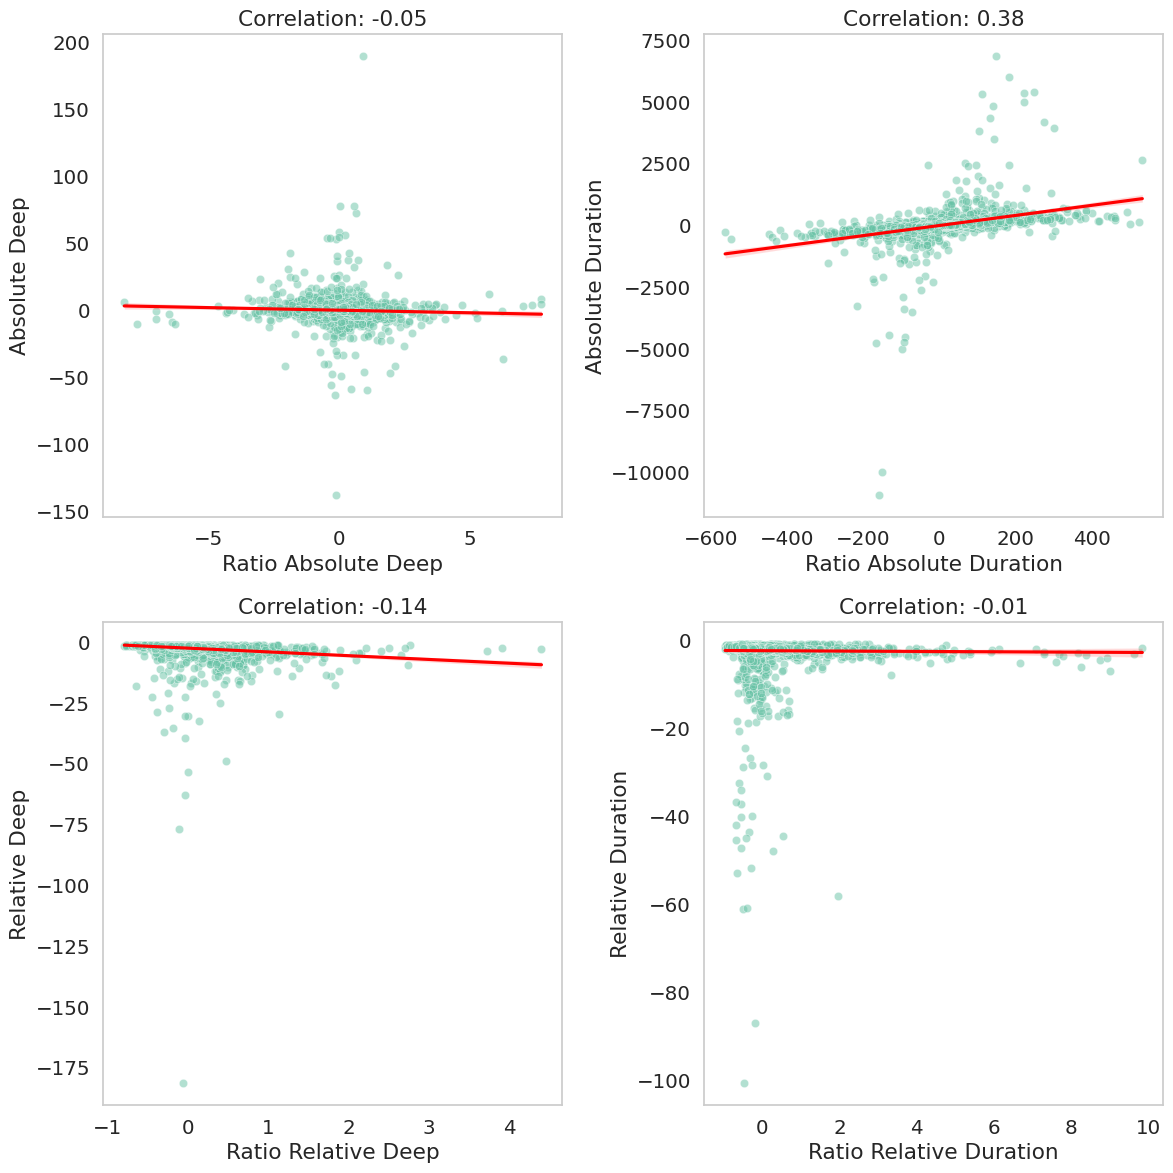

In [51]:
(
    values_absolute_deep,
    values_absolute_duration,
    values_ratio_absolute_deep,
    values_ratio_absolute_duration,
    values_relative_deep,
    values_relative_duration,
    values_ratio_relative_deep,
    values_ratio_relative_duration,
) = experiment_func_agreg_by_linearization(data, 0.1, 3, n_iter=n_iter, eta=0.5)

def plot_all_correlations(data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (x, y, xlabel, ylabel) in enumerate(data):
        row, col = divmod(i, 2)  # Определяем строку и колонку для подграфика
        ax = axes[row, col]
        
        sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax)

        # Линейная регрессия
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax)

        # Корреляция Пирсона
        correlation = np.corrcoef(x, y)[0, 1]
        ax.set_title(f"Correlation: {correlation:.2f}")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

    plt.tight_layout()
    plt.show()

# Данные для построения графиков
info_plot = [
    (values_ratio_absolute_deep, values_absolute_deep, "Ratio Absolute Deep", "Absolute Deep"),
    (values_ratio_absolute_duration, values_absolute_duration, "Ratio Absolute Duration", "Absolute Duration"),
    (values_ratio_relative_deep, values_relative_deep, "Ratio Relative Deep", "Relative Deep"),
    (values_ratio_relative_duration, values_relative_duration, "Ratio Relative Duration", "Relative Duration")
]

plot_all_correlations(info_plot, labels=None)


  0%|          | 0/5000 [00:00<?, ?it/s]

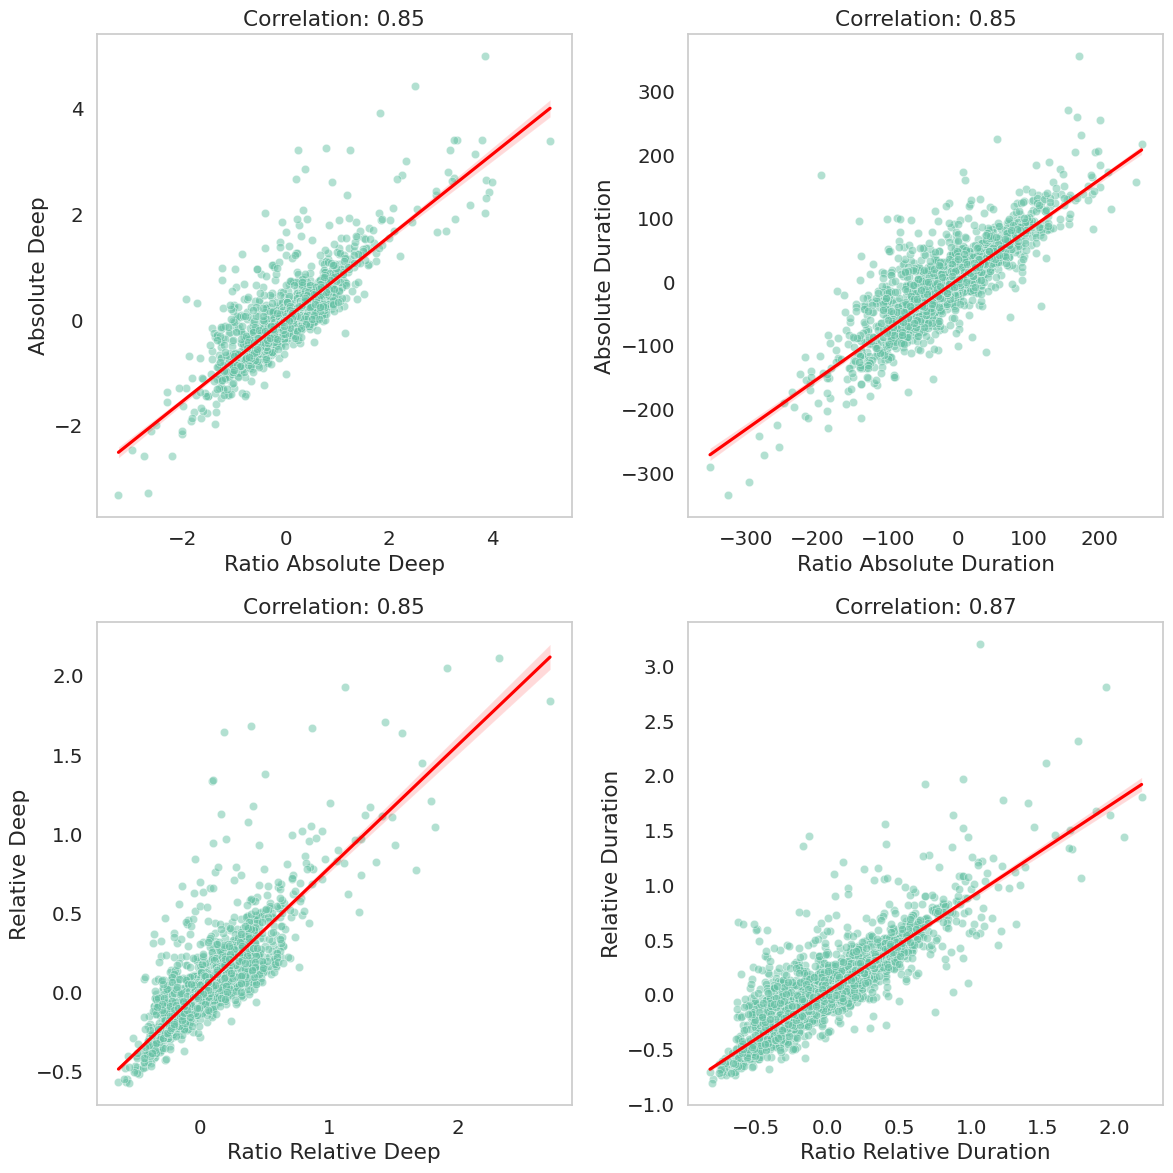

In [52]:
(
    values_absolute_deep,
    values_absolute_duration,
    values_ratio_absolute_deep,
    values_ratio_absolute_duration,
    values_relative_deep,
    values_relative_duration,
    values_ratio_relative_deep,
    values_ratio_relative_duration,
) = experiment_func_agreg_by_bucket(data, 0.2, 5, n_iter=n_iter)

def plot_all_correlations(data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (x, y, xlabel, ylabel) in enumerate(data):
        row, col = divmod(i, 2)  # Определяем строку и колонку для подграфика
        ax = axes[row, col]
        
        sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax)

        # Линейная регрессия
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax)

        # Корреляция Пирсона
        correlation = np.corrcoef(x, y)[0, 1]
        ax.set_title(f"Correlation: {correlation:.2f}")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

    plt.tight_layout()
    plt.show()

# Данные для построения графиков
info_plot = [
    (values_ratio_absolute_deep, values_absolute_deep, "Ratio Absolute Deep", "Absolute Deep"),
    (values_ratio_absolute_duration, values_absolute_duration, "Ratio Absolute Duration", "Absolute Duration"),
    (values_ratio_relative_deep, values_relative_deep, "Ratio Relative Deep", "Relative Deep"),
    (values_ratio_relative_duration, values_relative_duration, "Ratio Relative Duration", "Relative Duration")
]

plot_all_correlations(info_plot, labels=None)


В целом можно для некоторых графиков можно говорить о сонаправленности, но разброс все равно не маленький.

**2.** Провалидируй эксперимент из предыдущих домашек для линеаризации с CUPED и стратификацией.

По сути, сделать надо примерно то же самое, но добавить линеаризацию. Бери код линеаризации с занятия, а также реализацию теста с линеаризацией и CUPED. А также, может быть, код из предыдущих домашек. В общем, из нескольких реализаций надо сделать одну общую.

In [53]:
def weighted_mean(data, weights):
    """
    Вычисляет взвешенное среднее.

    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    """

    strata_means = data.groupby(by="strata")["sample"].mean()
    return (strata_means * weights).sum()


def simple_mean(data, weights):
    """
    Вычисляет обычное выборочное среднее

    :param data: данные
    :param weights: не используется, нужен для совместимости
    :return: выборочное среднее
    """

    return data["sample"].mean()


def stratified_sampler(data, sample_size):
    """
    Стратифицированное семплирование выборок.

    :param data: данные
    :param sample_size: размер выборки
    :return: две выборки
    """

    # Веса страт
    strata_weights = calculate_strata_weights(data)

    # Размер выборок
    strata_sample_size = np.floor(sample_size * strata_weights + 0.5).astype(int)

    a_group, b_group = [], []
    # Генерируем для каждой страты отдельно
    for i, strata in enumerate(data.groupby(by="strata")):
        a, b = random_sampler(strata[1], strata_sample_size[i])
        a_group.append(a)
        b_group.append(b)

    return pd.concat(a_group), pd.concat(b_group)


def sample_mean_diff(sampler, mean_function, data, sample_size, n_iter):
    """
    Реализация итераций семплирования двух групп и вычисления разности средних.

    :param sampler: функция семплирования двух групп
    :param mean_function: функция вычисления среднего
    :param data: исходные данные
    :param sample_size: размер группы
    :param n_iter: количество итераций семплирования
    :return: выборка разности средних
    """

    # Веса страт
    strata_weights = calculate_strata_weights(data)

    mean_sample = np.zeros(n_iter)

    for i in tqdm(range(n_iter)):
        # Семплирование
        groups = sampler(data, sample_size)
        # Вычисление разности средних
        mean_sample[i] = mean_function(groups[0], strata_weights) - mean_function(
            groups[1], strata_weights
        )

    return mean_sample


def weighted_var(data, strata_weights):
    """
    Вычисляет взвешенную дисперсию при стратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    """

    strata_vars = data.groupby(by="strata")["sample"].var()
    return (strata_vars * strata_weights).sum() / len(data)


def weighted_post_var(data, strata_weights):
    """
    Вычисляет взвешенную дисперсию при постстратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    """

    strata_vars = data.groupby(by="strata")["sample"].var()
    weighted_var = (strata_vars * strata_weights).sum() / len(data)
    post_addition = (strata_vars * (1 - strata_weights)).sum() / (len(data) ** 2)
    return weighted_var + post_addition


def simple_var(data, strata_weights):
    """
    Вычисляет обычную дисперсию при случайном семплировании.

    :param data: данные
    :param strata_weights: веса страт, не используется, нужен для совместимости
    :return: дисперсия
    """

    return data["sample"].var() / len(data)


def calculate_strata_weights(data):
    """
    Вычисляет веса страт.

    :param data: исходные данные
    :return: веса страт
    """

    strata_weights = data.groupby(by="strata")["sample_not_strat"].count()
    strata_weights = strata_weights / strata_weights.sum()
    return strata_weights


def random_sampler(data, sample_size):
    """
    Случайное семплирование двух групп одного размера из данных.

    :param data: исходные данные
    :param sample_size: размер группы
    :return: две группы данных
    """

    choiced = data.sample(n=2 * sample_size)
    return choiced.iloc[:sample_size], choiced.iloc[-sample_size:]


def sample_mean_diff(data, sample_size, n_iter):
    """
    Реализация итераций семплирования двух случайных групп и вычисления разности средних.

    :param data: исходные данные
    :param sample_size: размер группы
    :param n_iter: количество итераций семплирования
    :return: выборка разности средних
    """

    mean_sample = np.zeros(n_iter)

    for i in tqdm(range(n_iter)):
        groups = random_sampler(data, sample_size)
        mean_sample[i] = groups[0]["sample"].mean() - groups[1]["sample"].mean()

    return mean_sample


def stratified_ttest(x_data, y_data, strata_weights, method="random", alpha=0.05):
    """
    Стратифицированный абсолютный t-test.

    :param x_data: выборка вместе с информацией о стратах
    :param y_data: выборка вместе с информацией о стратах
    :param strata_weights: веса страт
    :param method: метод 'random', 'stratified', 'post_stratified'
    :param alpha: уровень значимости
    :return: статистика критерия, границы доверительного интервала, p-value
    """

    if method == "random":
        mean_function = simple_mean
        var_function = simple_var
    elif method == "stratified":
        mean_function = weighted_mean
        var_function = weighted_var
    elif method == "post_stratified":
        mean_function = weighted_mean
        var_function = weighted_post_var

    x_mean = mean_function(x_data, strata_weights)
    y_mean = mean_function(y_data, strata_weights)
    x_var = var_function(x_data, strata_weights)
    y_var = var_function(y_data, strata_weights)

    stat = x_mean - y_mean
    std = np.sqrt(x_var + y_var)

    t_stat = stat / std
    pvalue = 2 * sps.norm.sf(np.abs(t_stat))

    q = sps.norm.ppf(1 - alpha / 2)
    left_bound = stat - q * std
    right_bound = stat + q * std

    return stat, pvalue, left_bound, right_bound

In [54]:
def test_simulation(
    test,
    data,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="sample_not_strat",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    strata_weights = calculate_strata_weights(data)
    # Генерируем выборки
    control_data, test_data = generate_sample_control(data, sample_size=sample_size)
    # Добавляем эффект, если хотим оценить мощность
    if relative_effect:
        test_data[feature_values] *= 1 + effect * (test_data["period"] == 1)
    else:
        test_data[feature_values] += effect * (test_data["period"] == 1)

    return test(control_data, test_data, strata_weights)[1]


def run_experiments(
    test,
    generate_sample_control,
    data,
    generate_sample_test=None,
    feature_values="sample_not_strat",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            data,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals=show_pvals,
            pvals=pvals,
            alpha=alpha,
            figsize=figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)


def random_sampler(data, sample_size):
    """
    Случайное семплирование двух групп одного размера из данных.

    :param data: исходные данные
    :param sample_size: размер группы
    :return: две группы данных
    """

    choiced = data.sample(n=2 * sample_size)
    return choiced.iloc[:sample_size], choiced.iloc[-sample_size:]

In [55]:
def linearization_ratio_stratified_ttest(
    control_data,
    test_data,
    strata_weights,
    cuped=True,
    numerator_name="sample_not_strat",
    denominator_name=None,
    user_name="ym:s:clientID",
    strata_name="strata",
    eta=0,
    alpha=0.05,
):
    """
    T-test для ratio-метрик с учетом стратификации, линеаризации и CUPED.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп (до разбиения)
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    strata_name -- имя колонки, по которой выполняется стратификация
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "sample" if cuped else "sample_not_strat"

    # Линеаризация
    control_users_pilot, test_users_pilot = linearization(
        control_data[control_data["period"] == 1],
        test_data[test_data["period"] == 1],
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    if cuped:
        control_users_prepilot, test_users_prepilot = linearization(
            control_data[control_data["period"] == 0],
            test_data[test_data["period"] == 0],
            numerator_name=numerator_name,
            denominator_name=denominator_name,
            user_name=user_name,
            eta=eta,
        )
        
        # Мердж данных с заполнением пропусков
        control_users_pilot = control_users_pilot.merge(
            control_users_prepilot[["linearization_values"]], 
            left_on=user_name, 
            right_index=True,
            suffixes=('', '_prepilot'),
            how='left'
        ).fillna(0)
        
        test_users_pilot = test_users_pilot.merge(
            test_users_prepilot[["linearization_values"]], 
            left_on=user_name, 
            right_index=True,
            suffixes=('', '_prepilot'),
            how='left'
        ).fillna(0)

        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="linearization_values",
            cuped_name=name,
            covariate_name="linearization_values_prepilot",
        )
    else:
        control_data, test_data = control_users_pilot, test_users_pilot
    # t-test
    if not cuped:
        control_data["sample"] = control_data[name]
        test_data["sample"] = test_data[name]


    stat, pval, left_bound, right_bound = stratified_ttest(test_data[["sample", "strata"]], control_data[["sample", "strata"]], strata_weights)
    # res = sps.ttest_ind(test_data[name], control_data[name])
    
    # Доверительный интервал
    coef = eta * control_data[denom].mean() + (1 - eta) * test_data[denom].mean()
    left_bound /= coef
    right_bound /= coef

    return stat, pval, left_bound, right_bound

В качестве страты возьмем os

In [56]:
data = pd.read_csv(
    "miptstats_metrica.tsv",
    sep="\t",
)
data["ym:s:dateTimeUTC"] = pd.to_datetime(data["ym:s:dateTimeUTC"])
data = data[["ym:s:clientID", "ym:s:dateTimeUTC", "ym:s:pageViews", "ym:s:operatingSystemRoot"]]
data.head()

ym:s:clientID    ym:s:dateTimeUTC  ym:s:pageViews  \
0  1568056026568729022 2020-01-01 03:28:50               1   
1  1577864187752491163 2020-01-01 10:36:27               9   
2  1567765219104836417 2020-01-01 11:40:44               2   
3  1576839432510419026 2020-01-01 11:50:13               1   
4  1576246599115183097 2020-01-01 12:17:33               2   

  ym:s:operatingSystemRoot  
0                gnu_linux  
1               ios_double  
2               ios_double  
3                  android  
4                gnu_linux

In [57]:
os = data["ym:s:operatingSystemRoot"].unique()
os = [x for x in os if x not in ["bsd", "nan", "google_chrome_os", "tizen", np.nan]]

last_df = data.loc[
    data["ym:s:operatingSystemRoot"].isin(os),
    ["ym:s:clientID", "ym:s:operatingSystemRoot", "ym:s:pageViews", "ym:s:dateTimeUTC"],
].copy()
last_df.loc[:, "strata"] = last_df["ym:s:operatingSystemRoot"]
last_df.rename(columns={"ym:s:pageViews": "sample_not_strat"}, inplace=True)
last_df.drop(columns=["ym:s:operatingSystemRoot"], inplace=True)

last_df.head()

ym:s:clientID  sample_not_strat    ym:s:dateTimeUTC      strata
0  1568056026568729022                 1 2020-01-01 03:28:50   gnu_linux
1  1577864187752491163                 9 2020-01-01 10:36:27  ios_double
2  1567765219104836417                 2 2020-01-01 11:40:44  ios_double
3  1576839432510419026                 1 2020-01-01 11:50:13     android
4  1576246599115183097                 2 2020-01-01 12:17:33   gnu_linux

Эксперимент как мы помним, проводится в апреле, поэтому в качестве теста возьмем промежуток времени с февраля по май 2023, а контроль предыдущие промежутки с февраля по май.

In [58]:
last_df["period"] = np.where(
    (last_df["ym:s:dateTimeUTC"] < pd.Timestamp("2023-06-01")) & 
    (last_df["ym:s:dateTimeUTC"] > pd.Timestamp("2023-02-01")), 
    1, 
    0
)

last_df = last_df[
    (last_df["ym:s:dateTimeUTC"].dt.month >= 2) & 
    (last_df["ym:s:dateTimeUTC"].dt.month <= 5) & 
    (last_df["ym:s:dateTimeUTC"].dt.year >= 2020) & 
    (last_df["ym:s:dateTimeUTC"].dt.year <= 2023)
]

In [59]:
last_df.drop(columns=["ym:s:dateTimeUTC"], inplace=True)

In [60]:
last_df.head()

ym:s:clientID  sample_not_strat      strata  period
1128  1568037737625002167                 3     windows       0
1129  1580537452838907656                 2  ios_double       0
1130  1577950804375545185                 2     android       0
1131  1580540127733882007                 1     android       0
1132  1580120860338802470                 1     android       0

С CUPED

  0%|          | 0/5000 [00:00<?, ?it/s]

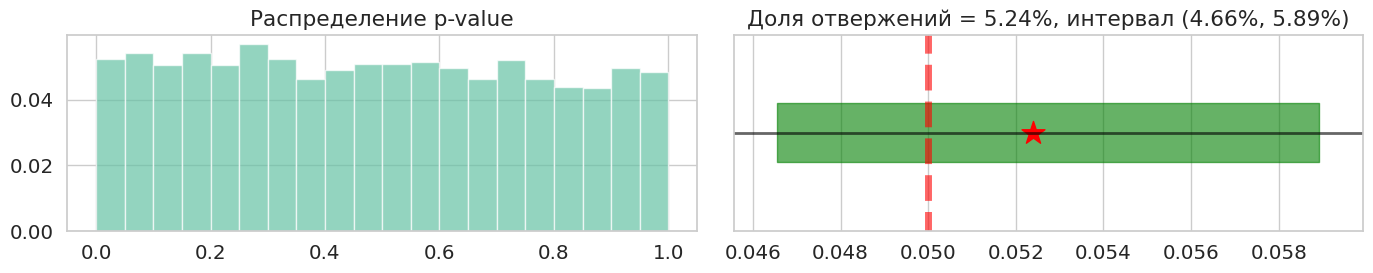

(0.0524, (0.046559956706276516, 0.05892729007493864))

In [61]:
run_experiments(
    test=lambda x, y, weights: linearization_ratio_stratified_ttest(
        x,
        y,
        strata_weights=weights,
        cuped=True,
        numerator_name="sample_not_strat",
        user_name="ym:s:clientID",
        eta=0
    ),
    data=last_df,
    generate_sample_control=random_sampler,
    sample_size=last_df.shape[0] // 20,
    n_iter=n_iter ,
    draw=True,
)

Без CUPED

  0%|          | 0/5000 [00:00<?, ?it/s]

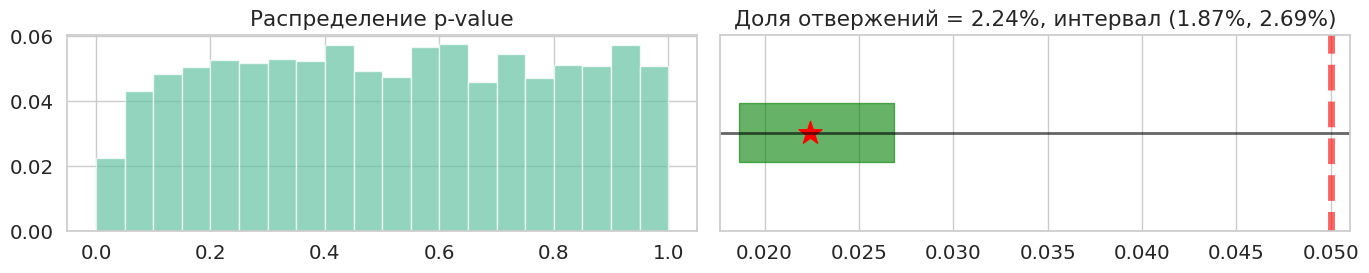

(0.0224, (0.018650132017796132, 0.026883176880122435))

In [62]:
run_experiments(
    test=lambda x, y, weights: linearization_ratio_stratified_ttest(
        x,
        y,
        strata_weights=weights,
        cuped=False,
        numerator_name="sample_not_strat",
        user_name="ym:s:clientID",
        eta=0
    ),
    data=last_df,
    generate_sample_control=random_sampler,
    sample_size=last_df.shape[0] // 20,
    n_iter=n_iter,
    draw=True,
)

Сравни критерии по линеаризованной метрике по мощности при использовании CUPED и в простом случае.

In [63]:
effects_list = np.arange(0, 0.7, 0.1)
powers1 = np.zeros(len(effects_list))
left_bounds1 = np.zeros(len(effects_list))
right_bounds1 = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers1[i], (left_bounds1[i], right_bounds1[i]) = run_experiments(
    test=lambda x, y, weights: linearization_ratio_stratified_ttest(
        x,
        y,
        strata_weights=weights,
        cuped=True,
        numerator_name="sample_not_strat",
        user_name="ym:s:clientID",
        eta=0
    ),
    data=last_df,
    generate_sample_control=random_sampler,
    sample_size=last_df.shape[0] // 20,
    n_iter=1000,
    draw=False,
    show_pvals=False,
    effect=effect
)

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
effects_list = np.arange(0, 0.7, 0.1)
powers2 = np.zeros(len(effects_list))
left_bounds2 = np.zeros(len(effects_list))
right_bounds2 = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers2[i], (left_bounds2[i], right_bounds2[i]) = run_experiments(
    test=lambda x, y, weights: linearization_ratio_stratified_ttest(
        x,
        y,
        strata_weights=weights,
        cuped=False,
        numerator_name="sample_not_strat",
        user_name="ym:s:clientID",
        eta=0
    ),
    data=last_df,
    generate_sample_control=random_sampler,
    sample_size=last_df.shape[0] // 20,
    n_iter=1000,
    draw=False,
    show_pvals=False,
    effect=effect
)


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности (массив или список массивов/объектов)
    left_powers, right_powers -- границы соотв. доверительного интервала (массив или список)
    effects_list -- сетка эффектов
    label -- подпись графика (строка или список строк)
    title -- заголовок графика
    new_figure -- создавать новую фигуру или нет
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    # Преобразуем одиночные массивы в списки, если передали только один набор данных
    if not isinstance(powers, (list, tuple)):
        powers = [powers]
        left_powers = [left_powers]
        right_powers = [right_powers]
        label = [label] if label else [None]

    # Рисуем все переданные графики мощности
    for i, (p, lp, rp) in enumerate(zip(powers, left_powers, right_powers)):
        # Если передан объект, извлекаем из него нужные атрибуты
        if hasattr(p, "powers"):
            lp, rp = p.left_powers, p.right_powers
            p = p.powers

        plt.plot(effects_list, p, label=label[i] if label else None, lw=3)
        plt.fill_between(effects_list, lp, rp, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )

    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)



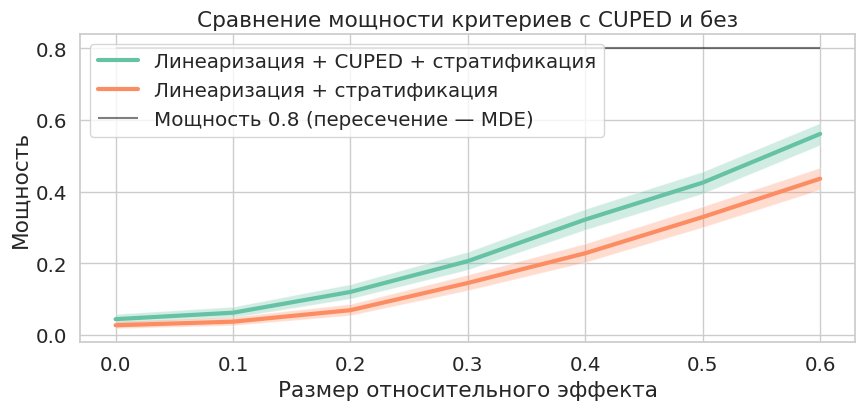

In [66]:
draw_power(
    [powers1, powers2],
    [left_bounds1, left_bounds2],
    [right_bounds1, right_bounds2],
    label=["Линеаризация + CUPED + стратификация", "Линеаризация + стратификация"],
    title="Сравнение мощности критериев с CUPED и без",
    new_figure=True,
    effects_list=effects_list,
)
plt.show()

**Вывод:** 

Мы увидили, что использование бакетов и линеаризации помогает улучшить сонаправленность данных.

Также, вновь убедились, но линеаризация не мешает CUPED, а потому метод с ним имеет большую мощность, чем без него.

Вот и все, задание закончилось, вроде же хорошо мы вместе решили задачки, правда?)